# A360 Metadetection Shear

Contact author: Miranda Gorsuch

Create a shear profile for A360 using cell-based coadds and `metadetection`. Many parts are from the [Shear profile around A360 using ComCam HSM shapes](https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSCcalib_CLMM.ipynb) notebook, especially the identification of red sequence galaxies and use of CLMM to create the tangential shear plot.

Last working weekly: `w_2025_41`

Container Size: 16 GB (large)

# Preparing data

## Imports & Definitions

In [6]:
# locally install modeling packages (only do once, if not already installed)
# !pip install pyccl
# !pip install clmm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 14.8 MB/s  0:00:01m0:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyccl: filename=pyccl-3.2.1-py3-none-any.whl size=2554697 sha256=50a92dfae82429cb3d65f54bede660c2776a6c4f544812ebe67bd74d87d61c73
  Stored in directory: /home/m/mgorsuch/.cache/pip/wheels/6a/c6/b3/8c615e580e91c465ac418bb0937c4a8b84e925fd2b8800781f
Successfully built pyccl
Defaulting to user installation because normal site-packages is not writeable
  Using cached clmm-1.16.5-py3-none-any.whl.metadata (10 kB)
Using cached clmm-1.16.5-py3-none-any.whl (90 kB)


In [1]:
from lsst.daf.butler import Butler

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib

import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

import gc

from lsst.skymap import Index2D
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.geom as geom

# for stats control
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.meas.algorithms as meas

from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

from numpy.linalg import inv
import scipy.stats as stats
from scipy.stats import chi2, norm
from scipy.spatial import KDTree

import healsparse as hsp

import qp
import pickle

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
h = 0.7
cl_z = 0.22
%matplotlib inline

# Position in degrees of the BCG for A360
ra_bcg = 37.865017
dec_bcg = 6.982205

REPO = '/sdf/data/rubin/repo/main/'
butler = Butler(REPO)
registry = butler.registry

In [2]:
meas_type = 'gauss'

# with noise correlations
if meas_type == 'wmom':
    collection = 'u/mgorsuch/metadetect/a360_3_band/noise/20250827T213552Z'
elif meas_type == 'gauss':
    collection = 'u/mgorsuch/metadetect/a360_3_band_gauss/noise/20250827T214428Z'
elif meas_type == 'pgauss':
    collection = 'u/mgorsuch/metadetect/a360_3_band_pgauss/noise/20250827T215647Z'
else:
    print("Not an available measurement type")

cell_collection = 'u/mgorsuch/ComCam_Cells/a360/corr_noise_cells/20250822T224002Z'

The functions `detect_sig` and `gal_den_profile` are based on https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_HSM_HSCcalib_CLMM_forTN.ipynb

In [3]:
# get detection significance from a GC Object
def detect_sig(gc_object):
    gamma_t = gc_object.profile['gt']
    sigma_t = gc_object.profile['gt_err']
    gamma_x = gc_object.profile['gx']
    sigma_x = gc_object.profile['gx_err']
    
    # Compute chi-squared statistic (compared to null hypothesis)
    chi2_stat_t = np.sum((gamma_t / sigma_t)**2)
    chi2_stat_x = np.sum((gamma_x / sigma_x)**2)
    dof = len(gamma_t)
    
    # Compute p-value from chi-squared distribution
    p_value_t = 1 - chi2.cdf(chi2_stat_t, dof)
    p_value_x = 1 - chi2.cdf(chi2_stat_x, dof)
    
    # Convert p-value to significance in sigma
    significance_sigma_t = norm.isf(p_value_t)  # isf = inverse survival function (1 - CDF)
    significance_sigma_x = norm.isf(p_value_x)  # isf = inverse survival function (1 - CDF)
    
    # Print results
    print("Tangential signal")
    print(f"Chi-squared statistic: {chi2_stat_t:.3f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p_value_t:.4e}")
    print(f"Detection significance: {significance_sigma_t:.2f} sigma")
    print("\nCross signal")
    print(f"Chi-squared statistic: {chi2_stat_x:.3f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p_value_x:.4e}")
    print(f"Detection significance: {significance_sigma_x:.2f} sigma")

# get galaxy density plot from a GC Object
NOBJ = int(1e8) # Number of randoms to Monte-Carlo sample over

def gal_den_profile(gc_object, heal_mask):
    
    gal_density = []
    gal_density_err = []
    for i,rbin in enumerate(gc_object.profile):
        Ngal = gc_object.profile[i]['n_src']
        rmin = gc_object.profile[i]['radius_min']
        rmax = gc_object.profile[i]['radius_max']

        theta_min = cosmo.mpc2rad(rmin, 0.22)*180*60/np.pi # arcmin
        theta_max = cosmo.mpc2rad(rmax, 0.22)*180*60/np.pi # arcmin

        theta_deg_min = cosmo.mpc2rad(rmin, 0.22)*180/np.pi # degrees
        theta_deg_max = cosmo.mpc2rad(rmax, 0.22)*180/np.pi # degrees

        # calculate area with masked area removed
        circ_min = hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=theta_deg_min, value=1)
        circ_max = hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=theta_deg_max, value=1)

        smap_min = circ_min.get_map(nside_coverage=32, nside_sparse=32768, dtype=np.int16)
        smap_max = circ_max.get_map(nside_coverage=32, nside_sparse=32768, dtype=np.int16)
        smap = smap_max.apply_mask(smap_min, in_place=False) # remove hsp pixels from inner circle
        
        ra_rand, dec_rand = hsp.make_uniform_randoms_fast(smap, NOBJ)
        mask_rand = ~heal_mask['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)
        prop_kept = np.count_nonzero(mask_rand)/NOBJ
        
        print(Ngal)
        total_area = np.pi*(theta_max*theta_max - theta_min*theta_min) # sq arcmin
        gal_density.append(Ngal/(prop_kept*total_area))
        gal_density_err.append(np.sqrt(Ngal)/(prop_kept*total_area))

    # get global number density
    Ngal = np.sum(gc_object.profile['n_src'])
    rmax = gc_object.profile[-1]['radius_max']

    theta_max = cosmo.mpc2rad(rmax, 0.22)*180*60/np.pi # arcmin
    theta_deg_max = cosmo.mpc2rad(rmax, 0.22)*180/np.pi # degrees

    # calculate area with masked area removed
    circ_max = hsp.Circle(ra=ra_bcg, dec=dec_bcg, radius=theta_deg_max, value=1)
    smap = circ_max.get_map(nside_coverage=32, nside_sparse=32768, dtype=np.int16)
    
    ra_rand, dec_rand = hsp.make_uniform_randoms_fast(smap, NOBJ)
    mask_rand = ~heal_mask['full_mask'].get_values_pos(ra_rand, dec_rand, lonlat=True)
    prop_kept = np.count_nonzero(mask_rand)/NOBJ
    
    total_area = np.pi*(theta_max*theta_max) # sq arcmin
    total_gal_density = Ngal/(prop_kept*total_area)
    total_gal_density_err = np.sqrt(Ngal)/(prop_kept*total_area)
    print(f"Total galaxy density (per sq arcmin): {total_gal_density}, error: {total_gal_density_err}")

    return gc_object.profile['radius'], gal_density, gal_density_err

def plot_blendedness(catalog, bins, blended_cut, pz_tree, desc):
    '''
    Match the input catalog to the DP1 catalog to get the i_blendedness values.
    
    Plot the fraction of objects over the blendedness cut for each bin.
    '''
    # select the ns catalog to be matched, or ensure there is ns only
    ns_catalog = catalog[catalog['shear_type']=='ns'].copy()
    dig_mpc_bins = np.digitize(ns_catalog['mpc_sep'], bins)
    blendedness = 0 # variable to store column of i_blendedness

    meta_coords = np.vstack((ns_catalog['ra'], ns_catalog['dec'])).T
    # ndxs are the indices of pz_coords during pz_tree intialization
    dists, ndxs =  pz_tree.query(meta_coords, k=2) 

    # this removes quite a few items which increases difficulty in adding to pandas, filter is added in the .loc function
    goodmatch_filt_temp = dists[:,0] < 1/3600
    
    blendedness = pz_data[ndxs]['i_blendedness']
    ns_catalog['blendedness'] = blendedness[:,0]
    
    ns_catalog.loc[~goodmatch_filt_temp, "blendedness"] = np.nan
    
    blendedness_frac = []

    for i in range(0, len(bins)-1):
        bin_filt = dig_mpc_bins == i+1
    
        catalog_bin = ns_catalog[bin_filt]
    
        num_bin = catalog_bin["blendedness"].count() # ignore nan values from above in count
        num_blended = catalog_bin[catalog_bin['blendedness']>blended_cut]['blendedness'].count()
        print(num_bin, num_blended/(num_bin))
    
        blendedness_frac.append(num_blended/(num_bin))

    # plot the results
    bins_mid = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
    
    plt.scatter(bins_mid, blendedness_frac)
    plt.title(f"Blendedness vs distance from cluster center, {desc} \n i_blendedness > {blended_cut}")
    plt.ylabel(r"fraction blended")
    plt.xlabel("Distance from cluster center [Mpc]")
    plt.show()

## Read in data

### Start from the Butler

Metadetect outputs tables for each patch. Read in each table and compile them together.

In [4]:
datasetRefs_shear = []
overlap_patches_10463 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
tract_patch_list = [] # only used for plotting distribution of input images

for ref in butler.registry.queryDatasets('ShearObject', collections=collection):

    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue
    
    datasetRefs_shear.append(butler.query_datasets('ShearObject', 
                                                     collections=collection,
                                                     skymap = 'lsst_cells_v1',
                                                     tract=ref.dataId['tract'],
                                                     patch=ref.dataId['patch']))

    tract_patch_list.append([ref.dataId['tract'], ref.dataId['patch']])

10463 64
10463 84
10463 44
10463 63
10464 97
10464 77
10464 57
10464 78
10463 71
10463 91
10464 67
10463 61
10463 41
10463 92
10464 87
10463 81
10464 48
10464 99
10463 62
10464 38
10463 42
10463 31
10463 82
10464 68
10463 52
10464 37
10464 89
10464 69
10463 51
10464 58
10464 49
10463 32
10463 83
10463 72
10464 39
10464 79
10463 73
10463 33
10464 59
10463 93
10463 53
10463 54
10463 43
10463 94


Combine the data from each patch into a single table.

In [5]:
shear_table_list = []

for i, ref in enumerate(datasetRefs_shear):
    shear_data_patch = butler.get(ref[0])
    shear_table_patch = shear_data_patch.to_pandas()
    shear_table_list.append(shear_table_patch)

shear_table = pd.concat(shear_table_list)

# remove unused tables to clear up memory
del shear_table_list
gc.collect()

604

In [14]:
# save raw catalogs if desired
# if meas_type == 'wmom':
#     shear_table_wl.to_pickle("./md-raw-wmom.pkl")
# elif meas_type == 'gauss':
#     shear_table_wl.to_pickle("./md-raw-gauss.pkl")
# elif meas_type == 'pgauss':
#     shear_table_wl.to_pickle("./md-raw-pgauss.pkl")
# else:
#     print("Not an available measurement type")

Remove objects flagged by Metadetection - anything flagged should be removed.

In [6]:
# see how many flagged objects are initially in catalog
meta_filter = shear_table[f'{meas_type}_flags']==False
meta_filter &= shear_table['psfrec_flags']==False
meta_filter &= shear_table[f'{meas_type}_psf_flags']==False
meta_filter &= shear_table[f'{meas_type}_obj_flags']==False
meta_filter &= shear_table[f'{meas_type}_T_flags']==False
meta_filter &= shear_table[f'{meas_type}_band_flux_flags_r']==False
meta_filter &= shear_table[f'{meas_type}_band_flux_flags_i']==False

print("Total number of objects from the raw catalog: ", len(shear_table))
print("Total number of objects from the raw catalog in ns: ", len(shear_table[shear_table['shear_type']=='ns']))
shear_table = shear_table[meta_filter]
# print("Number of rows after removing metadetect flags: ", len(shear_table[meta_filter]))
# print("Number of rows in ns after removing metadetect flags: ", len(shear_table[meta_filter][shear_table[meta_filter]['shear_type']=='ns']))
print("Number of rows after removing metadetect flags: ", len(shear_table))
print("Number of rows in ns after removing metadetect flags: ", len(shear_table[shear_table['shear_type']=='ns']))

Total number of objects from the raw catalog:  1398239
Total number of objects from the raw catalog in ns:  279985
Number of rows after removing metadetect flags:  984169
Number of rows in ns after removing metadetect flags:  196810


### Remove duplicate objects

In [7]:
# copy table prior to duplicate removal for a later validation plot
shear_table_dup = shear_table.copy()

Remove duplicate objects from patch overlap.

In [8]:
# remove objects in outer ring of cells in each patch since patch overlap is two cells
# TO-DO: exempt rows that don't overlap with other patches, e.g. patches on the edge of the field
shear_table = shear_table[shear_table['cell_x']!=0]
shear_table = shear_table[shear_table['cell_x']!=21]
shear_table = shear_table[shear_table['cell_y']!=0]
shear_table = shear_table[shear_table['cell_y']!=21]
print("Number of rows after removing most duplicate cells: ", len(shear_table))
print("Number of rows after removing most duplicate cells in ns: ", len(shear_table[shear_table['shear_type']=='ns']))

# some additional tract/patch overlap appears to have a 4 cell overlap
filt1 = shear_table['tract'] == 10464
filt1 &= shear_table['patch_x'] == 9
filt1 &= shear_table['cell_x'] == 20
shear_table = shear_table[np.invert(filt1)]

filt2 = shear_table['tract'] == 10463
filt2 &= shear_table['patch_x'] == 1
filt2 &= shear_table['cell_x'] == 1
shear_table = shear_table[np.invert(filt2)]

print()
print("Number of rows after removing patch overlap areas: ", len(shear_table))
print("Number of rows after removing patch overlap areas in ns: ", len(shear_table[shear_table['shear_type']=='ns']))

# remove overlapping rows due to patch overlap    
print("Number of rows prior to removing duplicates: ", len(shear_table))
shear_table = shear_table.drop_duplicates(subset=['shear_type', 'ra', 'dec']) # each object will potentially have several sheared images
print("Number of rows after removing duplicates: ", len(shear_table))
print("Number of rows after removing duplicates in ns: ", len(shear_table[shear_table['shear_type']=='ns']))

# concating the per-patch catalogs together results in non-unique indices
shear_table.reset_index(inplace=True)

Number of rows after removing most duplicate cells:  817884
Number of rows after removing most duplicate cells in ns:  163572

Number of rows after removing patch overlap areas:  805401
Number of rows after removing patch overlap areas in ns:  161078
Number of rows prior to removing duplicates:  805401
Number of rows after removing duplicates:  805392
Number of rows after removing duplicates in ns:  161074


Remove duplicate objects from cell overlap.

In [9]:
# is there a better way to do this? Probably
dup_cell_ndx = []

for i, tract_patch in enumerate(tract_patch_list):
        
    tract = tract_patch[0]
    patch = tract_patch[1]

    coadd = butler.get("deepCoaddCell", 
                    tract=tract, 
                    patch=patch, 
                    band='i', 
                    skymap='lsst_cells_v1', 
                    collections=cell_collection)

    shear_len_before = len(shear_table)

    for cell_index in coadd.cells:
        cell = coadd.cells[Index2D(x=cell_index.x, y=cell_index.y)]
        cell_center = cell.inner.bbox.getCenter()

        # find objects in this cell
        filt_loc = shear_table['tract'] == tract
        filt_loc &= shear_table['patch_y'] == (patch - (patch % 10)) // 10
        filt_loc &= shear_table['patch_x'] == (patch % 10)
        filt_loc &= shear_table['cell_x'] == cell_index.x
        filt_loc &= shear_table['cell_y'] == cell_index.y

        cell_objs = shear_table[filt_loc]

        if len(cell_objs)==0:
            continue
            
        # identify those objects that are beyond the inner cell region 
        # 75 pixels from the center in either dimension (inner cell length is 150 pixels)
        outer_filt = cell_objs['col'] > (cell_center[0] + 75)
        outer_filt |= cell_objs['col'] < (cell_center[0] - 75)
        outer_filt |= cell_objs['row'] > (cell_center[1] + 75)
        outer_filt |= cell_objs['row'] < (cell_center[1] - 75)

        dup_cell_ndx.extend(cell_objs[outer_filt].index.to_list())

    print(tract_patch)
    del coadd
    gc.collect()

[10463, 64]
[10463, 84]
[10463, 44]
[10463, 63]
[10464, 97]
[10464, 77]
[10464, 57]
[10464, 78]
[10463, 71]
[10463, 91]
[10464, 67]
[10463, 61]
[10463, 41]
[10463, 92]
[10464, 87]
[10463, 81]
[10464, 48]
[10464, 99]
[10463, 62]
[10464, 38]
[10463, 42]
[10463, 31]
[10463, 82]
[10464, 68]
[10463, 52]
[10464, 37]
[10464, 89]
[10464, 69]
[10463, 51]
[10464, 58]
[10464, 49]
[10463, 32]
[10463, 83]
[10463, 72]
[10464, 39]
[10464, 79]
[10463, 73]
[10463, 33]
[10464, 59]
[10463, 93]
[10463, 53]
[10463, 54]
[10463, 43]
[10463, 94]


In [10]:
dup_cell_ndx = np.unique(dup_cell_ndx)
shear_table.drop(dup_cell_ndx, inplace=True)

print("Number of objects after duplicates removes: ", len(shear_table))
print("Number of objects in ns after duplicates removes: ", len(shear_table[shear_table['shear_type']=='ns']))

Number of objects after duplicates removes:  443615
Number of objects in ns after duplicates removes:  88733


### Add useful columns

In [11]:
# make new columns to convert nJy fluxes to AB magnitudes
t1 = Table.from_pandas(shear_table)

t1[f'{meas_type}_band_mag_g'] = (t1[f'{meas_type}_band_flux_g']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_band_mag_r'] = (t1[f'{meas_type}_band_flux_r']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_band_mag_i'] = (t1[f'{meas_type}_band_flux_i']*u.nJy).to(u.ABmag)
t1[f'{meas_type}_color_mag_g-r'] = t1[f'{meas_type}_band_mag_g']-t1[f'{meas_type}_band_mag_r']
t1[f'{meas_type}_color_mag_g-i'] = t1[f'{meas_type}_band_mag_g']-t1[f'{meas_type}_band_mag_i']
t1[f'{meas_type}_color_mag_r-i'] = t1[f'{meas_type}_band_mag_r']-t1[f'{meas_type}_band_mag_i']

shear_table = t1.to_pandas()

# Add columns for distance from BCG
c1 = SkyCoord(shear_table['ra'].values*u.deg, shear_table['dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

shear_table['deg_sep'] = sep.value

shear_table['mpc_sep'] = cosmo.eval_da(0.22) * shear_table['deg_sep'] * np.pi/180

# uncertainties, flux errors are 1 standard deviation
shear_table[f'{meas_type}_mag_g_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_g'] / shear_table[f'{meas_type}_band_flux_g'])
shear_table[f'{meas_type}_mag_r_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_r'] / shear_table[f'{meas_type}_band_flux_r'])
shear_table[f'{meas_type}_mag_i_err'] = (2.5 / np.log(10)) * (shear_table[f'{meas_type}_band_flux_err_i'] / shear_table[f'{meas_type}_band_flux_i'])

/opt/lsst/software/stack/conda/envs/lsst-scipipe-11.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


### Save / Read Catalogs

In [12]:
# save catalog so far
# if meas_type == 'wmom':
#     shear_table.to_pickle("./md-dup-wmom.pkl")
# elif meas_type == 'gauss':
#     shear_table.to_pickle("./md-dup-gauss.pkl")
# elif meas_type == 'pgauss':
#     shear_table.to_pickle("./md-dup-pgauss.pkl")
# else:
#     print("Not an available measurement type")

# read in catalog to skip other steps
if meas_type == 'wmom':
    shear_table = pd.read_pickle("./md-dup-wmom.pkl")
elif meas_type == 'gauss':
    shear_table = pd.read_pickle("./md-dup-gauss.pkl")
elif meas_type == 'pgauss':
    shear_table = pd.read_pickle("./md-dup-pgauss.pkl")
else:
    print("Not an available measurement type")

## Identify and remove cluster member galaxies (all r axes)

Text(0.5, 0.98, 'Object Magnitudes')

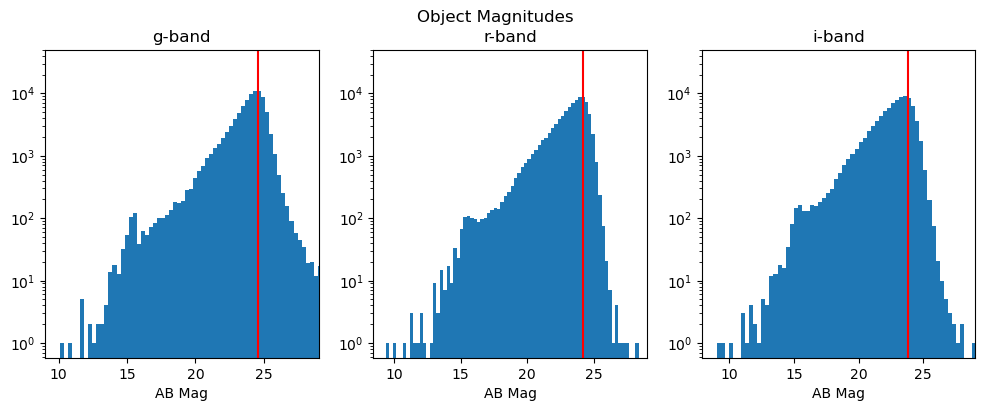

In [13]:
# isolate no shear catalog
shear_table_ns = shear_table[shear_table['shear_type']=='ns']

# pick plot parameters based on measurement type
if meas_type == 'wmom':
    g_line, r_line, i_line = 25.7, 25.4, 25.0
    ymax = 50000
elif meas_type == 'gauss':
    g_line, r_line, i_line = 24.6, 24.2, 23.8
    ymax = 50000
elif meas_type == 'pgauss':
    g_line, r_line, i_line = 24.8, 24.4, 24.0
    ymax = 50000
else:
    print("Not an available measurement type")

# distribution of magnitudes prior to cuts
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].hist(shear_table_ns[f'{meas_type}_band_mag_g'], bins=75)
ax[0].set_title("g-band")
ax[0].vlines(x=g_line, ymin=0, ymax=ymax, color='red')
ax[1].hist(shear_table_ns[f'{meas_type}_band_mag_r'], bins=75)
ax[1].set_title("r-band")
ax[1].vlines(x=r_line, ymin=0, ymax=ymax, color='red')
ax[2].hist(shear_table_ns[f'{meas_type}_band_mag_i'], bins=75)
ax[2].set_title("i-band")
ax[2].vlines(x=i_line, ymin=0, ymax=ymax, color='red')

for ax in ax.reshape(-1):
    ax.set_yscale('log')
    ax.set_xlabel("AB Mag")
    ax.set_xlim(right=29)
    ax.set_ylim(top=ymax)

plt.savefig(f'image_outputs_{meas_type}/object-magnitudes.png', bbox_inches='tight')
plt.suptitle("Object Magnitudes")

In [105]:
shear_table_wl = shear_table[shear_table['deg_sep'] < 0.5].copy() # catalog for WL measurements
print("Number of rows after applying < 0.5 deg from center: ", len(shear_table_wl))
print("Number of rows in ns after applying < 0.5 deg from center: ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))

Number of rows after applying < 0.5 deg from center:  271058
Number of rows in ns after applying < 0.5 deg from center:  54228


In [106]:
# plotting parameters
point_size = 0.6
point_alpha = 0.7

mag_lim = 24
bright_lim = 18

# how many sigma to include in RS selection
sigma = 1

if meas_type == 'wmom':
    # slope, upper range, lower range
    rs_range = [(-0.09, 2.15, 1.85), # g-i
                (-0.03, 0.67, 0.47), # r-i
                (-0.07, 1.53, 1.37)] # g-r
elif meas_type == 'gauss':
    rs_range = [(-0.06, 2.05, 1.75),
                (-0.03, 0.63, 0.50),
                (-0.04, 1.43, 1.25)]
elif meas_type == 'pgauss':
    rs_range = [(-0.08, 2.05, 1.85),
                (-0.025, 0.62, 0.5),
                (-0.05, 1.45, 1.28)]
else:
    print("Not an available measurement type")

In [107]:
def RS_id(table, sigma, mag_lim, bright_lim, rs_range):

    # ranges
    gi_table_line_up = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[0][0]) + rs_range[0][1]
    ri_table_line_up = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[1][0]) + rs_range[1][1]
    gr_table_line_up = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[2][0]) + rs_range[2][1]
    
    gi_table_line_down = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[0][0]) + rs_range[0][2]
    ri_table_line_down = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[1][0]) + rs_range[1][2]
    gr_table_line_down = (table[f'{meas_type}_band_mag_r'] - 18) * (rs_range[2][0]) + rs_range[2][2]
    
    gi_err = np.sqrt(table[f'{meas_type}_mag_g_err']**2 + table[f'{meas_type}_mag_i_err']**2)
    ri_err = np.sqrt(table[f'{meas_type}_mag_r_err']**2 + table[f'{meas_type}_mag_i_err']**2)
    gr_err = np.sqrt(table[f'{meas_type}_mag_g_err']**2 + table[f'{meas_type}_mag_r_err']**2)

    gi_err_up = table[f'{meas_type}_color_mag_g-i'] + sigma * gi_err
    gi_err_down = table[f'{meas_type}_color_mag_g-i'] - sigma * gi_err
    ri_err_up = table[f'{meas_type}_color_mag_r-i'] + sigma * ri_err
    ri_err_down = table[f'{meas_type}_color_mag_r-i'] - sigma * ri_err
    gr_err_up = table[f'{meas_type}_color_mag_g-r'] + sigma * gr_err
    gr_err_down = table[f'{meas_type}_color_mag_g-r'] - sigma * gr_err

    '''
    There are 4 cases that we want to consider for RS selection:
    - Case 1: RS data without errors is within RS selection
    - Case 2: Upper error bar end is within RS selection
    - Case 3: Lower error bar end is within RS selection
    - Case 4: Upper error bar is above RS selection
                AND lower error bar is below RS selection

    An object that falls within any of these cases should be selected.
    '''

    gi_redseq = np.logical_and.reduce((np.logical_or.reduce((
                                            np.logical_and.reduce((
                                                table[f'{meas_type}_color_mag_g-i'] < gi_table_line_up,
                                                table[f'{meas_type}_color_mag_g-i'] > gi_table_line_down,)),
                                            np.logical_and.reduce((
                                                gi_err_up < gi_table_line_up,
                                                gi_err_up > gi_table_line_down,)),
                                            np.logical_and.reduce((
                                                gi_err_down < gi_table_line_up,
                                                gi_err_down > gi_table_line_down,)),
                                            np.logical_and.reduce((
                                                gi_err_up > gi_table_line_up,
                                                gi_err_down < gi_table_line_down,)),
                                       )),
                                       table[f'{meas_type}_band_mag_r'] < mag_lim, 
                                       table[f'{meas_type}_band_mag_r'] > bright_lim))

    ri_redseq = np.logical_and.reduce((np.logical_or.reduce((
                                            np.logical_and.reduce((
                                                table[f'{meas_type}_color_mag_r-i'] < ri_table_line_up,
                                                table[f'{meas_type}_color_mag_r-i'] > ri_table_line_down,)),
                                            np.logical_and.reduce((
                                                ri_err_up < ri_table_line_up,
                                                ri_err_up > ri_table_line_down,)),
                                            np.logical_and.reduce((
                                                ri_err_down < ri_table_line_up,
                                                ri_err_down > ri_table_line_down,)),
                                            np.logical_and.reduce((
                                                ri_err_up > ri_table_line_up,
                                                ri_err_down < ri_table_line_down,)),
                                       )),
                                       table[f'{meas_type}_band_mag_r'] < mag_lim, 
                                       table[f'{meas_type}_band_mag_r'] > bright_lim))
    
    gr_redseq = np.logical_and.reduce((np.logical_or.reduce((
                                            np.logical_and.reduce((
                                                table[f'{meas_type}_color_mag_g-r'] < gr_table_line_up,
                                                table[f'{meas_type}_color_mag_g-r'] > gr_table_line_down,)),
                                            np.logical_and.reduce((
                                                gr_err_up < gr_table_line_up,
                                                gr_err_up > gr_table_line_down,)),
                                            np.logical_and.reduce((
                                                gr_err_down < gr_table_line_up,
                                                gr_err_down > gr_table_line_down,)),
                                            np.logical_and.reduce((
                                                gr_err_up > gr_table_line_up,
                                                gr_err_down < gr_table_line_down,)),
                                       )),
                                       table[f'{meas_type}_band_mag_r'] < mag_lim, 
                                       table[f'{meas_type}_band_mag_r'] > bright_lim))
    
    all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))

    redeq_ind = [gi_redseq, ri_redseq, gr_redseq]

    lines = [[gi_table_line_up, gi_table_line_down],
             [ri_table_line_up, ri_table_line_down],
             [gr_table_line_up, gr_table_line_down]]

    return all_redseq, redeq_ind, lines

In [108]:
# Single cell RS removal

all_redseq, _, _ = RS_id(shear_table_wl, sigma, mag_lim, bright_lim, rs_range)

# Filter out objects found in all_redseq
shear_table_wl = shear_table_wl[~all_redseq]
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']

print("Number of rows after 0.5 degree cut and RS cuts: ", len(shear_table_wl))
print("Number of rows after 0.5 degree cut and RS cuts, ns only: ", len(shear_table_wl_ns))

shear_table_rs_cuts = shear_table_wl.copy()

Number of rows after 0.5 degree cut and RS cuts:  258905
Number of rows after 0.5 degree cut and RS cuts, ns only:  51804


### Visual Inspection

In [18]:
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type'] == 'ns'].copy()
shear_table_rs = shear_table_wl[shear_table_wl['deg_sep'] < 0.1].copy()
shear_table_rs_ns = shear_table_rs[shear_table_rs['shear_type'] == 'ns']

#### Inner range of galaxies (< 0.1 Deg)

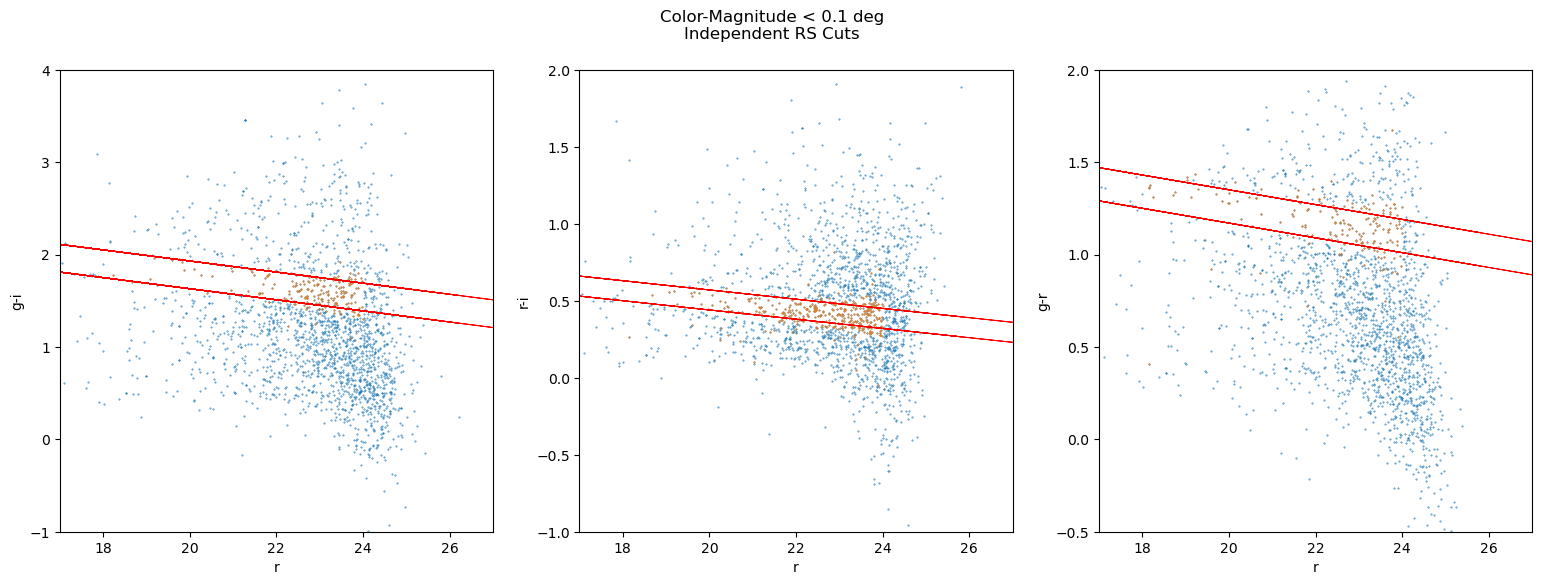

In [19]:
# ranges
all_redseq, redseq_list, lines = RS_id(shear_table_rs_ns, sigma, mag_lim, bright_lim, rs_range)

fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][redseq_list[0]], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-i'][redseq_list[0]], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[0][0], color='r', linewidth=0.7)
axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[0][1], color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][redseq_list[1]], 
           shear_table_rs_ns[f'{meas_type}_color_mag_r-i'][redseq_list[1]], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[1][0], color='r', linewidth=0.7)
axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[1][1], color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][redseq_list[2]], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-r'][redseq_list[2]], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[2][0], color='r', linewidth=0.7)
axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[2][1], color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.1 deg\nIndependent RS Cuts")
fig.savefig(f'image_outputs_{meas_type}/01-RS-indv_cuts.png')
plt.show()

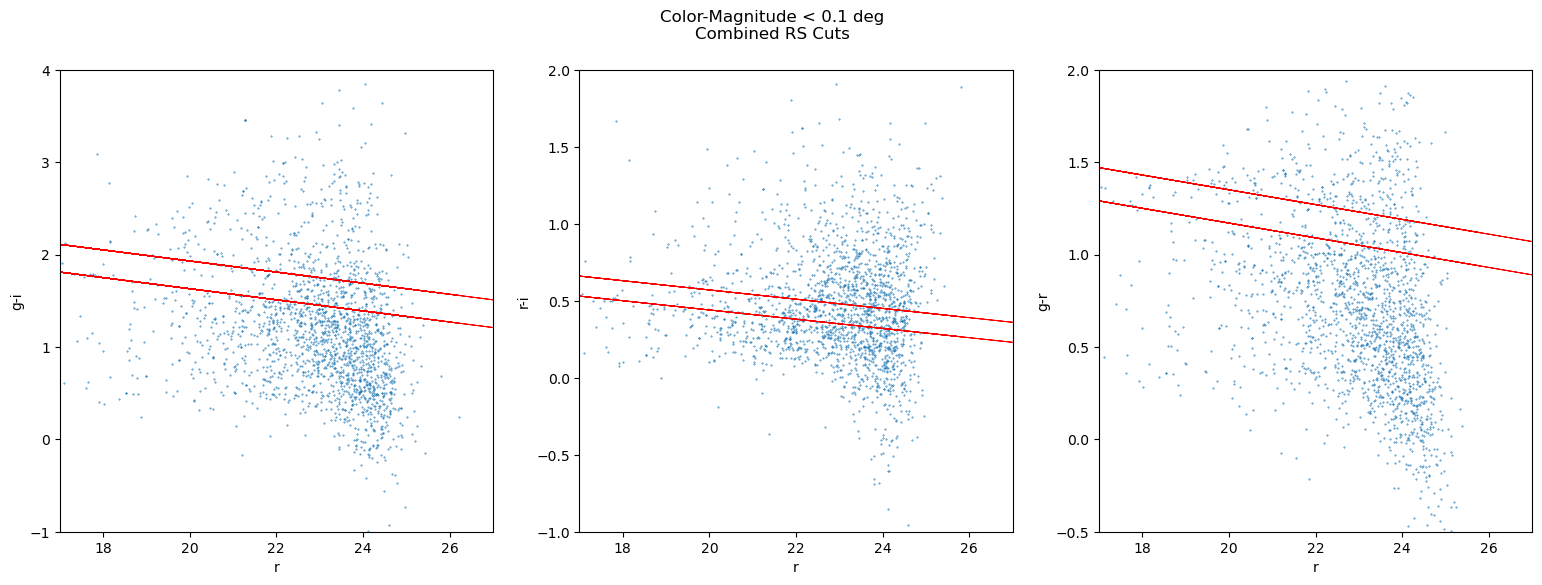

In [20]:
fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[0][0], color='r', linewidth=0.7)
axes[0].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[0][1], color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_r-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[1][0], color='r', linewidth=0.7)
axes[1].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[1][1], color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'], shear_table_rs_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_rs_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_rs_ns[f'{meas_type}_color_mag_g-r'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[2][0], color='r', linewidth=0.7)
axes[2].plot(shear_table_rs_ns[f'{meas_type}_band_mag_r'], lines[2][1], color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.1 deg\nCombined RS Cuts")
fig.savefig(f'image_outputs_{meas_type}/01-RS-all_cuts.png')
plt.show()

#### Most galaxies (< 0.5 Deg)

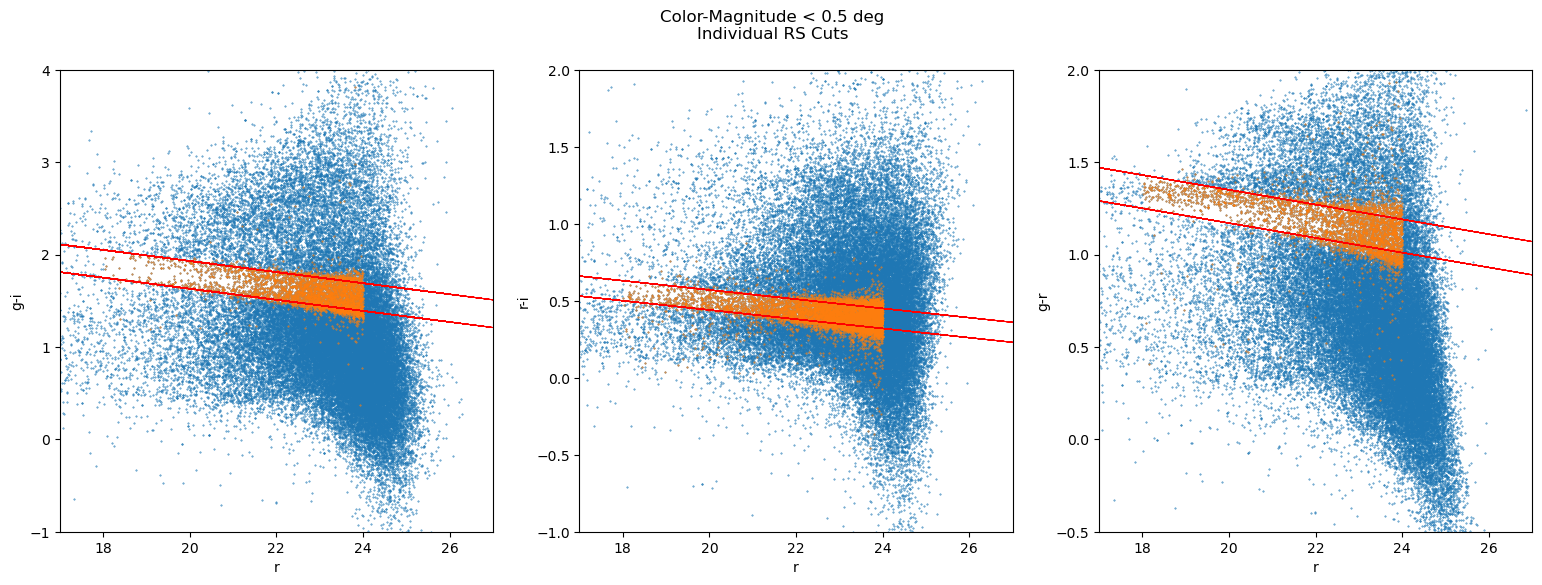

In [21]:
# ranges
all_redseq, redseq_list, lines = RS_id(shear_table_wl_ns, sigma, mag_lim, bright_lim, rs_range)

fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][redseq_list[0]], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-i'][redseq_list[0]], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][0], color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][1], color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][redseq_list[1]], 
           shear_table_wl_ns[f'{meas_type}_color_mag_r-i'][redseq_list[1]], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][0], color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][1], color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][redseq_list[2]], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-r'][redseq_list[2]], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][0], color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][1], color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nIndividual RS Cuts")
fig.savefig(f'image_outputs_{meas_type}/05-RS-indv_cuts.png')
plt.show()

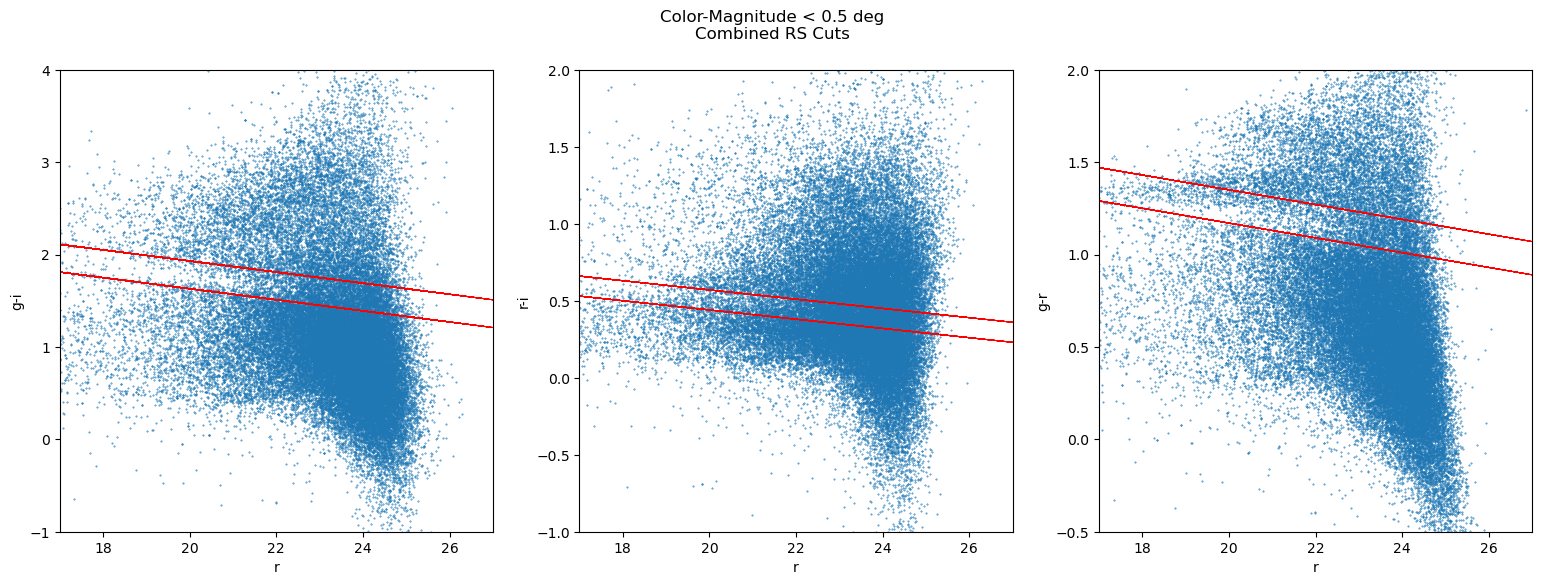

In [22]:
fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'], 
           marker='.', s=point_size) # all galaxies  
axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][0], color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][1], color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'], 
           marker='.', s=point_size) # all galaxies  
axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_r-i'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][0], color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][1], color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'], 
           marker='.', s=point_size) # all galaxies  
axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][all_redseq], 
           shear_table_wl_ns[f'{meas_type}_color_mag_g-r'][all_redseq], 
           marker='.', s=point_size) #red sequence galaxies
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][0], color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][1], color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nCombined RS Cuts")
fig.savefig(f'image_outputs_{meas_type}/05-RS-all_cuts.png')
plt.show()

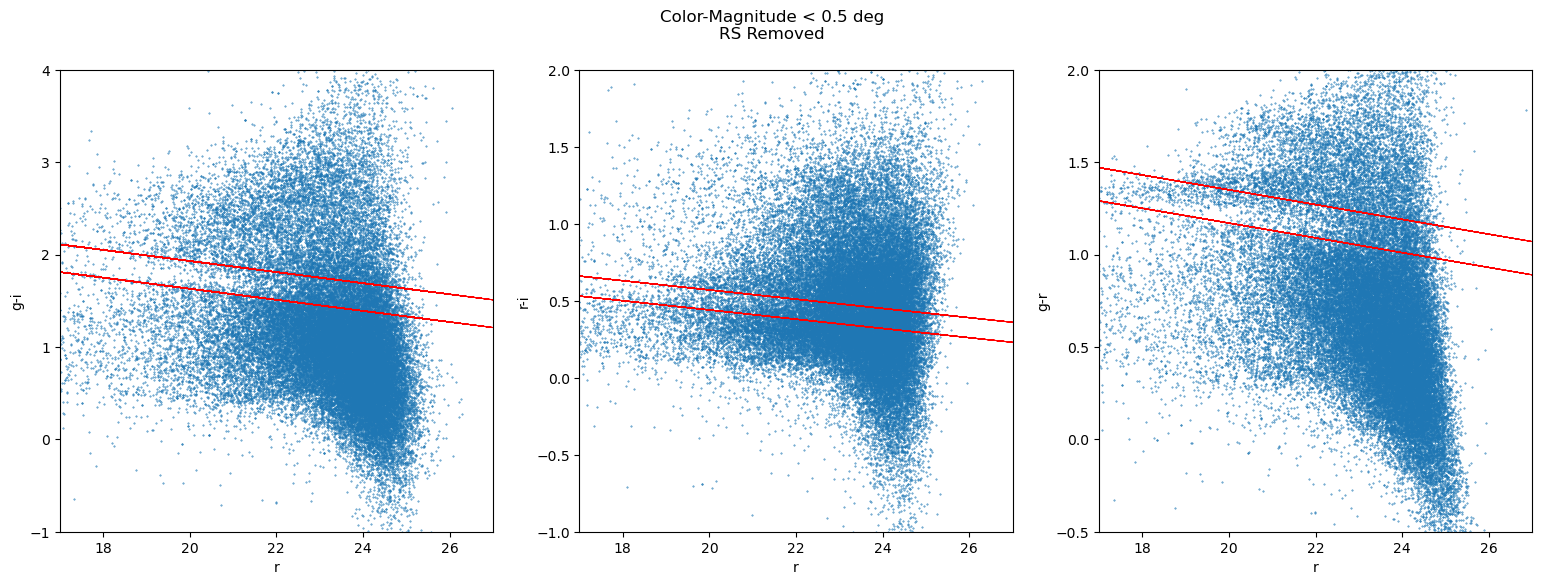

In [23]:
fig, axes = plt.subplots(1,3, figsize=(19, 6))

axes[0].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][~all_redseq], shear_table_wl_ns[f'{meas_type}_color_mag_g-i'][~all_redseq], 
           marker='.', s=point_size) # all galaxies  
axes[0].set_ylabel('g-i')
axes[0].set_xlabel('r')

axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][0], color='r', linewidth=0.7)
axes[0].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[0][1], color='r', linewidth=0.7)
axes[0].set_ylim([-1,4])
axes[0].set_xlim([17,27])

axes[1].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][~all_redseq], shear_table_wl_ns[f'{meas_type}_color_mag_r-i'][~all_redseq], 
           marker='.', s=point_size) # all galaxies  
axes[1].set_ylabel('r-i')
axes[1].set_xlabel('r')

axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][0], color='r', linewidth=0.7)
axes[1].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[1][1], color='r', linewidth=0.7)
axes[1].set_ylim([-1,2])
axes[1].set_xlim([17,27])

axes[2].scatter(shear_table_wl_ns[f'{meas_type}_band_mag_r'][~all_redseq], shear_table_wl_ns[f'{meas_type}_color_mag_g-r'][~all_redseq], 
           marker='.', s=point_size) # all galaxies  
axes[2].set_ylabel('g-r')
axes[2].set_xlabel('r')

axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][0], color='r', linewidth=0.7)
axes[2].plot(shear_table_wl_ns[f'{meas_type}_band_mag_r'], lines[2][1], color='r', linewidth=0.7)
axes[2].set_ylim([-0.5,2])
axes[2].set_xlim([17,27])

plt.suptitle("Color-Magnitude < 0.5 deg\nRS Removed")
fig.savefig(f'image_outputs_{meas_type}/05-RS-removed.png')
plt.show()

## Apply masks as done in mask technote

For example notebook, see [here](https://github.com/lsst-sitcom/comcam_clusters/blob/main/A360_masking_example.ipynb)

In [109]:
mask_hsp = hsp.HealSparseMap.read('/home/b/bclevine/A360/A360_full_mask_hsp_128_131072.parquet')

# mask = ~mask_hsp['full_mask'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True)
star_mask = ~mask_hsp['bo'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # bright objects
dust_mask = ~mask_hsp['sfd'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # masks from SFD dust map
hand_mask = ~mask_hsp['hand'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True)  # masks done by hand, e.g. galactic cirrus
exp_mask = ~mask_hsp['exp'].get_values_pos(shear_table_wl['ra'], shear_table_wl['dec'], lonlat=True) # edge / num exp mask

mask = star_mask & dust_mask & hand_mask & exp_mask

print("Number of rows in ns before mask applied: ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))
shear_table_wl = shear_table_wl[mask]
print("Number of rows in ns after mask applied : ", len(shear_table_wl[shear_table_wl['shear_type']=='ns']))

shear_table_masked = shear_table_wl.copy()

Number of rows in ns before mask applied:  51804
Number of rows in ns after mask applied :  40949


## Quality cuts

Some cuts based on [Yamamoto 2024](https://arxiv.org/abs/2501.05665) (such as T_ratio and color-color cuts)

In [110]:
# store cut values in a dictionary
if meas_type == 'wmom':
    mag_i = 24.0
    t_ratio = 1.20
elif meas_type == 'gauss':
    mag_i = 23.5
    t_ratio = 0.5
elif meas_type == 'pgauss':
    mag_i = 23.75
    t_ratio = 0.5
else:
    print("Not an available measurement type")

cut_dict = {'s2n' : 10,
            'T' : 20,
            'mfrac' : 0.1,
            'color' : 5,
            'bright' : 20,
            'mag_i' : mag_i,
            't_ratio' : t_ratio}

In [111]:
def print_rows_removed(og_table, meas_type, cut_dict, sigma):
    total = len(og_table)

    # create filter for star-galaxy cut
    sg_cut = og_table[f'{meas_type}_T_ratio'] > cut_dict['t_ratio']
    sg_cut &= (og_table[f'{meas_type}_T_ratio']-sigma*og_table[f'{meas_type}_T_err']) > cut_dict['t_ratio']
    
    print(f"{meas_type}_T_ratio rows removed: ", total-len(og_table[sg_cut]), "  (", \
    (1 - len(og_table[sg_cut]) / total))
    print(f"{meas_type}_band_mag_i rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']<=cut_dict['mag_i']]), "  (", \
    (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']<=cut_dict['mag_i']]) / total))
    print(f"{meas_type}_s2n rows removed: ", total-len(og_table[og_table[f'{meas_type}_s2n']>cut_dict['s2n']]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_s2n']>cut_dict['s2n']]) / total))
    print(f"{meas_type}_T rows removed: ", total-len(og_table[og_table[f'{meas_type}_T']<cut_dict['T']]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_T']<cut_dict['T']]) / total))
    print("m_frac rows removed: ", total-len(og_table[og_table['mfrac']<cut_dict['mfrac']]), "  (", \
        (1 - len(og_table[og_table['mfrac']<cut_dict['mfrac']]) / total))
    print(f"{meas_type}_color_mag_g-r rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_g-r']).abs()<cut_dict['color']]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_g-r']).abs()<cut_dict['color']]) / total))
    print(f"{meas_type}_color_mag_r-i rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_r-i']).abs()<cut_dict['color']]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_r-i']).abs()<cut_dict['color']]) / total))
    print(f"{meas_type}_color_mag_g-i rows removed: ", total-len(og_table[(og_table[f'{meas_type}_color_mag_g-i']).abs()<cut_dict['color']]), "  (", \
        (1 - len(og_table[(og_table[f'{meas_type}_color_mag_g-i']).abs()<cut_dict['color']]) / total))
    print(f"{meas_type}_band_mag_i<20 rows removed: ", total-len(og_table[og_table[f'{meas_type}_band_mag_i']>cut_dict['bright']]), "  (", \
        (1 - len(og_table[og_table[f'{meas_type}_band_mag_i']>cut_dict['bright']]) / total))

In [112]:
# cuts determined mainly from Yamamoto but also additional analyses here
sigma = 0

final_cuts = shear_table_wl[f'{meas_type}_s2n']>cut_dict['s2n']
final_cuts &= shear_table_wl[f'{meas_type}_T']<cut_dict['T']
final_cuts &= shear_table_wl['mfrac']<cut_dict['mfrac']
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_g-r']).abs()<cut_dict['color']
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_r-i']).abs()<cut_dict['color']
final_cuts &= (shear_table_wl[f'{meas_type}_color_mag_g-i']).abs()<cut_dict['color']
final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']>cut_dict['bright']
# final_cuts &= (shear_table[f'{meas_type}_T_ratio'] - sigma*(shear_table[f'{meas_type}_T_err']/shear_table[f'{meas_type}_psf_T'])>cut_dict['t_ratio'])
final_cuts &= (shear_table[f'{meas_type}_T_ratio']>cut_dict['t_ratio'])
final_cuts &= shear_table_wl[f'{meas_type}_band_mag_i']<=cut_dict['mag_i']
    
print_rows_removed(shear_table_wl, meas_type, cut_dict, sigma)

shear_table_wl = shear_table_wl[final_cuts]
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']

print()
print("Number of rows after applying quality cuts: ", len(shear_table_wl))
print("Number of rows in ns after applying quality cuts: ", len(shear_table_wl_ns))

gauss_T_ratio rows removed:  111442   ( 0.5443098564032431
gauss_band_mag_i rows removed:  74987   ( 0.366254762137345
gauss_s2n rows removed:  30335   ( 0.14816352447005954
gauss_T rows removed:  1847   ( 0.00902119761648923
m_frac rows removed:  0   ( 0.0
gauss_color_mag_g-r rows removed:  355   ( 0.0017339064178958363
gauss_color_mag_r-i rows removed:  49   ( 0.00023932792810388293
gauss_color_mag_g-i rows removed:  574   ( 0.002803555729217533
gauss_band_mag_i<20 rows removed:  11161   ( 0.0545130409299599

Number of rows after applying quality cuts:  65605
Number of rows in ns after applying quality cuts:  13114


In [113]:
# save the final sample
if meas_type == 'wmom':
    shear_table_wl.to_pickle("./md-wl-wmom.pkl")

    # also save as fits file
    shear_table_wl_table = Table.from_pandas(shear_table_wl)
    shear_table_wl_table.write('./md-wl-wmom.fits', overwrite=True)
elif meas_type == 'gauss':
    shear_table_wl.to_pickle("./md-wl-gauss.pkl")

    shear_table_wl_table = Table.from_pandas(shear_table_wl)
    shear_table_wl_table.write('./md-wl-gauss.fits', overwrite=True)
elif meas_type == 'pgauss':
    shear_table_wl.to_pickle("./md-wl-pgauss.pkl")

    shear_table_wl_table = Table.from_pandas(shear_table_wl)
    shear_table_wl_table.write('./md-wl-pgauss.fits', overwrite=True)
else:
    print("Not an available measurement type")

# read in if table is available
# if meas_type == 'wmom':
#     shear_table_wl = pd.read_pickle("./md-wl-wmom.pkl")
# elif meas_type == 'gauss':
#     shear_table_wl = pd.read_pickle("./md-wl-gauss.pkl")
# elif meas_type == 'pgauss':
#     shear_table_wl = pd.read_pickle("./md-wl-pgauss.pkl")
# else:
#     print("Not an available measurement type")

## Check shear types for each object

Each object is detected and measured separately for each sheared/unsheared image. The catalogs will not necessarily be the same but should be close in number of objects.

In [114]:
# split catalog by shear type
shear_table_wl_ns = shear_table_wl[shear_table_wl['shear_type']=='ns']
shear_table_wl_1p = shear_table_wl[shear_table_wl['shear_type']=='1p']
shear_table_wl_1m = shear_table_wl[shear_table_wl['shear_type']=='1m']
shear_table_wl_2p = shear_table_wl[shear_table_wl['shear_type']=='2p']
shear_table_wl_2m = shear_table_wl[shear_table_wl['shear_type']=='2m']

In [115]:
print("Number of shear type 'ns': ", len(shear_table_wl_ns))
print("Number of shear type '1p': ", len(shear_table_wl_1p))
print("Number of shear type '1m': ", len(shear_table_wl_1m))
print("Number of shear type '2p': ", len(shear_table_wl_2p))
print("Number of shear type '2m': ", len(shear_table_wl_2m))

Number of shear type 'ns':  13114
Number of shear type '1p':  13150
Number of shear type '1m':  13093
Number of shear type '2p':  13092
Number of shear type '2m':  13156


# Match to photo-z catalog

Methods from https://github.com/lsst-sitcom/comcam_clusters/blob/main/ACO360_WL_Anacal_PZmatching.ipynb

In [32]:
# Running at USDF RSP?
pz_sv38_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_sv38_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38'

pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']

In [33]:
bands = list('griz')
# bands = list('gri')
cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]
psf_bands = [b+suffix for b in bands for suffix in ['_psfFlux', '_psfFluxErr',  '_psfFlux_flag']]
extended_bands = [b+'_extendedness' for b in bands]

object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + cmodel_bands + gaap_bands + extended_bands + psf_bands

In [34]:
def load_pz_photomdata(tracts=[10463, 10464],
                       ddir='/sdf/data/rubin/shared/pz/data/dp1_v29.0.0_gold/',
                       suffix = 'pq',
                       columns=object_req_cols
                      ):
    object_cat = []

    for tract in tracts:
        tract_data = pd.read_parquet(ddir+str(tract)+'/object.' + suffix)
        relevant_data = Table.from_pandas(tract_data[columns])
        object_cat.append(relevant_data)

    preclean_table = vstack(object_cat)

    for b in list('griz'):
        preclean_table[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_cModelFlux'])
        preclean_table[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_gaap1p0Flux'])

    preclean_table['gi'] = preclean_table['g_gaap_mag'] - preclean_table['i_gaap_mag']
    preclean_table['gr'] = preclean_table['g_gaap_mag'] - preclean_table['r_gaap_mag']
    preclean_table['ri'] = preclean_table['r_gaap_mag'] - preclean_table['i_gaap_mag']

    c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
    c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
    sep = c1.separation(c2)
    preclean_table['sep'] = sep.deg
    return preclean_table

In [35]:
pz_data = load_pz_photomdata()
pz_coords = np.vstack((pz_data['coord_ra'], pz_data['coord_dec'])).T

pz_tree = KDTree(pz_coords)

/opt/lsst/software/stack/conda/envs/lsst-scipipe-11.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-11.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [36]:
pdf_bpz = qp.read(f'{pz_sv38_pdf_dir}/output_estimate_bpz.hdf5') # for individial p(z)
pz_point = pd.read_parquet(pz_sv38_point) # for point estimates

In [37]:
def get_mean_pz_all(pz_points, indices):
    
    filts = []

    for alg in pz_algs:
        if alg=='knn':
            filt = pz_points.iloc[indices][f"{alg}_z_median"].values
            filts.append(filt)
            continue
            
        filt = pz_points.iloc[indices][f"{alg}_z_mean"].values
        filts.append(filt)

    # calculate the mean value across each pz alg type
    mean_filt = np.mean(filts, axis=0)

    return mean_filt

In [38]:
def get_mean_pz(pz_points, indices, alg):
    
    filt = 0
    
    if alg=='knn':
        filt = pz_points.iloc[indices][f"{alg}_z_median"].values
    else:
        filt = pz_points.iloc[indices][f"{alg}_z_mean"].values

    return filt

In [39]:
def get_point_pz(pz_points, indices, alg, point_est):
    
    filt = 0
    
    if alg=='knn' and point_est=='mean':
        filt = pz_points.iloc[indices][f"{alg}_z_median"].values
    else:
        filt = pz_points.iloc[indices][f"{alg}_z_{point_est}"].values

    return filt

In [40]:
def get_pdfs(algo_type, filt, pz_dir, weights=None):
    '''
    This function will take the individual photo-z object PDFs and
    stack them to create an N(z). The filter provided will filter
    to keep only the matched objects.
    '''
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'{pz_dir}/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)
    if weights is None:
        stacked_plot = np.sum(pdf_plot, axis=0)
        normalized_plot = stacked_plot / len(filt)
    else:
        stacked_plot = np.dot(weights, pdf_plot)
        normalized_plot = stacked_plot / np.sum(weights)
        
    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [116]:
shear_catalogs = [shear_table_wl_ns, shear_table_wl_1p, shear_table_wl_1m, shear_table_wl_2p, shear_table_wl_2m]
dists_catalogs = []
shear_pz_catalogs = []
# initialize those only needed for NS catalog
goodmatch_filt = 0
ns_ndxs = 0
pdfs = []
obj_pzs = [] # variable to store `ns` catalog indivdual object's P(z) for each photo-z alg

pz_alg = ['dnf', 'fzboost', 'bpz']
point_est = 'mode'

for i, catalog in enumerate(shear_catalogs):

    catalog_og_len = len(catalog)
    
    meta_coords = np.vstack((catalog['ra'], catalog['dec'])).T

    # ndxs are the indices of pz_coords during pz_tree intialization
    dists, ndxs =  pz_tree.query(meta_coords, k=2) 

    goodmatch_filt_temp = dists[:,0] < 1/3600
    
    if i == 0:
        goodmatch_filt = goodmatch_filt_temp
        ns_ndxs = ndxs
        pdf_filt = ndxs[goodmatch_filt_temp,0]

        for alg in pz_alg:
            # generate a stacked N(z)
            pdf, _, xs = get_pdfs(alg, pdf_filt, pz_dir = pz_sv38_pdf_dir, weights=None)
            obj_pz = _
            
            # save the DNF individual P(z)
            np.save(f'./metadetect_{meas_type}_{alg}_pz', obj_pz)
            obj_pzs.append(obj_pz)
            
            # save the DNF stacked N(z)
            pdfs.append(pdf)
            np.save(f'./metadetect_{meas_type}_{alg}_nz', pdf)

    # calculate a per-object photo-z point estimate from the available PDFs

    # cut objects that are measured to be in front of the cluster
    catalog_cut = catalog[goodmatch_filt_temp].copy()

    if pz_alg == 'pz_all':
        catalog_cut[f'{pz_alg}_mean'] = get_mean_pz_all(pz_point, ndxs[goodmatch_filt_temp,0])
    else:
        for alg in pz_alg:
            catalog_cut[f'{alg}_{point_est}'] = get_point_pz(pz_point, ndxs[goodmatch_filt_temp,0], alg, point_est)

    print(f"Num metadetection: {catalog_og_len}. Num matches: {np.sum(goodmatch_filt_temp)}.")
    
    shear_pz_catalogs.append(catalog_cut)
    dists_catalogs.append(dists)

Num metadetection: 13114. Num matches: 10934.
Num metadetection: 13150. Num matches: 10983.
Num metadetection: 13093. Num matches: 10937.
Num metadetection: 13092. Num matches: 10916.
Num metadetection: 13156. Num matches: 10981.


Text(0.5, 1.0, 'Weighted $N(z)$')

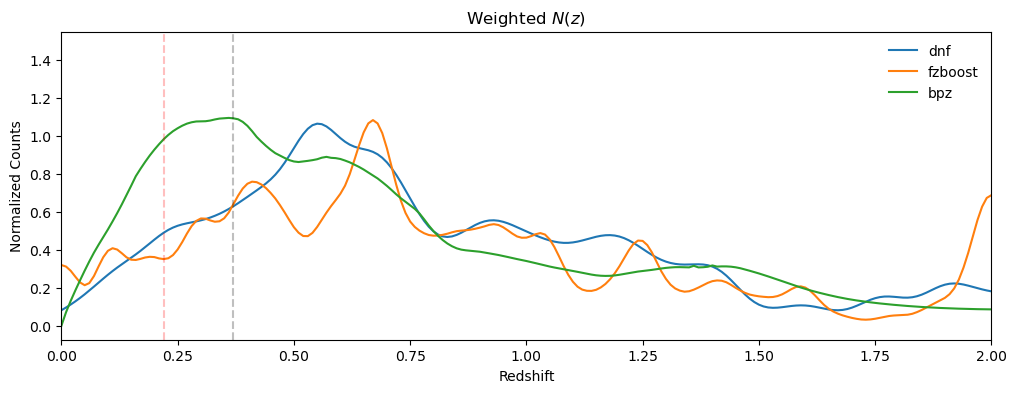

In [48]:
fig, ax = plt.subplots(1, figsize=(12, 4))

xs = np.linspace(0, 3, 301)
for i, alg in enumerate(pz_alg):
    ax.plot(xs, pdfs[i], label=pz_alg[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.set_title("Weighted $N(z)$")
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

In [117]:
# concat and save the entire matched photo-z catalog
# used for shear ratio tests that require all 5 catalogs for calibration

pz_catalog_wl_list = []

for catalog in shear_pz_catalogs:
    pz_catalog_wl_list.append(catalog)
    
pz_catalog_wl = pd.concat(pz_catalog_wl_list)
pz_catalog_wl.reset_index(inplace=True)

print(len(pz_catalog_wl))

pz_catalog_wl_table = Table.from_pandas(pz_catalog_wl)
pz_catalog_wl_table.write('./md-pz-gauss.fits', overwrite=True)

54751


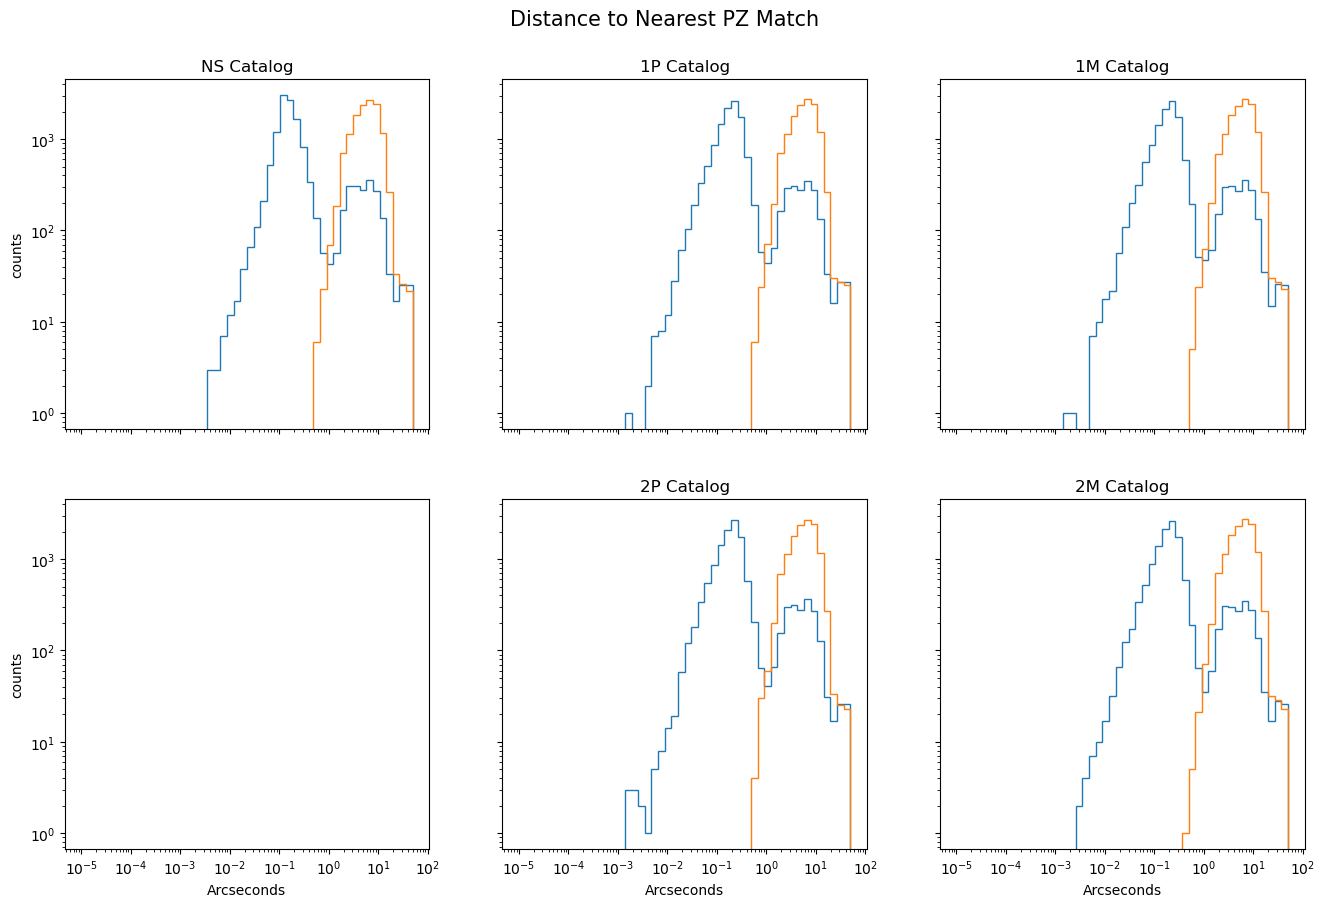

In [50]:
logbins = np.geomspace(1e-5, 50, 51)

fig, axes = plt.subplots(2,3, figsize=(16,10), sharex=True, sharey=True)
# plt.subplots_adjust(wspace=0, hspace=0)
 
axes[0][0].hist(dists_catalogs[0][:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
axes[0][0].hist(dists_catalogs[0][:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
axes[0][0].set_title("NS Catalog")
axes[0][0].set_ylabel("counts")

axes[0][1].hist(dists_catalogs[1][:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
axes[0][1].hist(dists_catalogs[1][:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
axes[0][1].set_title("1P Catalog")

axes[0][2].hist(dists_catalogs[2][:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
axes[0][2].hist(dists_catalogs[2][:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
axes[0][2].set_title("1M Catalog")

# leave [1][0] axes blank
axes[1][0].set_xlabel("Arcseconds")
axes[1][0].set_ylabel("counts")

axes[1][1].hist(dists_catalogs[3][:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
axes[1][1].hist(dists_catalogs[3][:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
axes[1][1].set_title("2P Catalog")
axes[1][1].set_xlabel("Arcseconds")

axes[1][2].hist(dists_catalogs[4][:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
axes[1][2].hist(dists_catalogs[4][:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
axes[1][2].set_title("2M Catalog")
axes[1][2].set_xlabel("Arcseconds")

for ax in axes.reshape(-1):
    ax.semilogx()
    ax.semilogy()

plt.suptitle("Distance to Nearest PZ Match", size=15, y=0.95)
# plt.savefig(f'image_outputs_{meas_type}/object-distribution-before-after.png', bbox_inches='tight')
plt.show()

### Look at blendedness of matched catalogs

In [95]:
bins = np.array([0.3, 0.7, 1.06495522, 1.62018517, 2.46489237, 3.75, 5, 6]) # Mpc
blended_cut = 0.35

127 0.007874015748031496
233 0.004291845493562232
500 0.0
1241 0.0040290088638195
2609 0.0038328861632809506
2987 0.002008704385671242
3327 0.003907424105801022


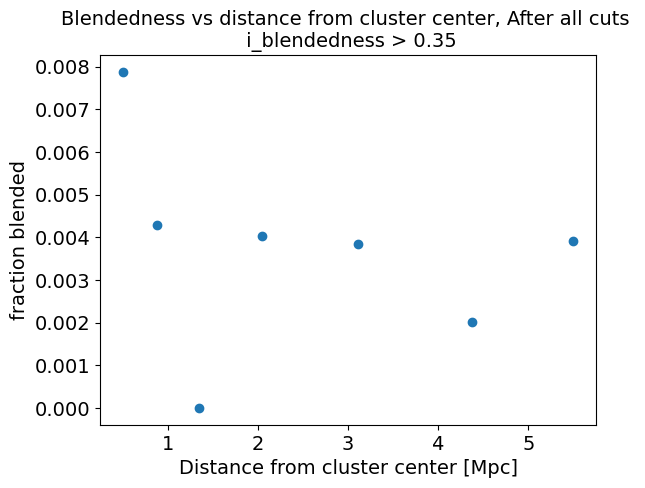

In [96]:
plot_blendedness(shear_table_wl_ns, bins, blended_cut, pz_tree, "After all cuts")

288 0.003472222222222222
517 0.0038684719535783366
1202 0.0008319467554076539
2993 0.0023387905111927833
6323 0.0022141388581369604
7415 0.0016183412002697235
8043 0.002237970906378217


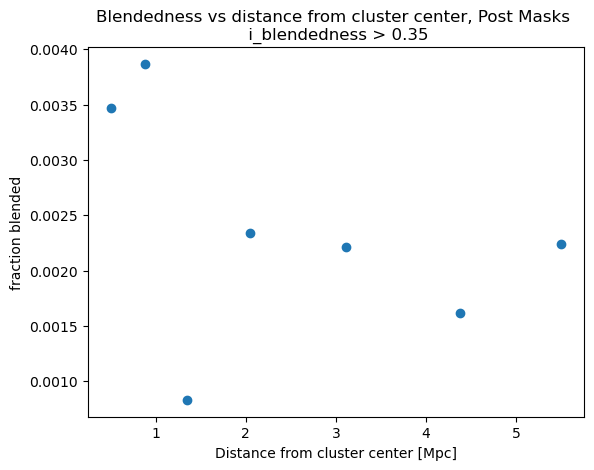

In [53]:
plot_blendedness(shear_table_masked, bins, blended_cut, pz_tree, "Post Masks")

371 0.0026954177897574125
594 0.003367003367003367
1458 0.0006858710562414266
3456 0.0026041666666666665
7723 0.0029781173119254175
10190 0.001962708537782139
9995 0.002701350675337669


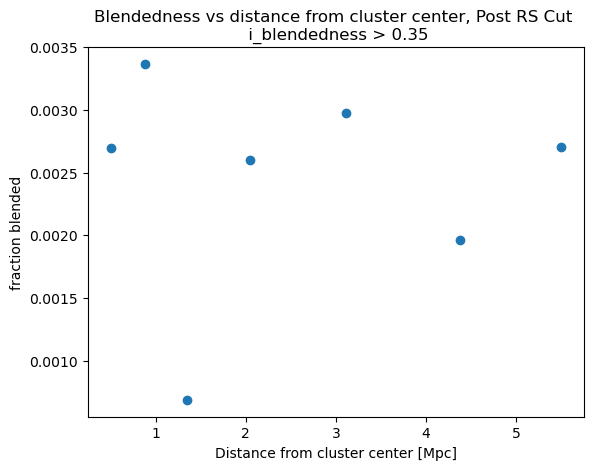

In [54]:
plot_blendedness(shear_table_rs_cuts, bins, blended_cut, pz_tree, "Post RS Cut")

479 0.010438413361169102
721 0.004160887656033287
1592 0.001256281407035176
3682 0.0027159152634437804
8092 0.002965892239248641
10610 0.0021677662582469366
10422 0.002782575321435425


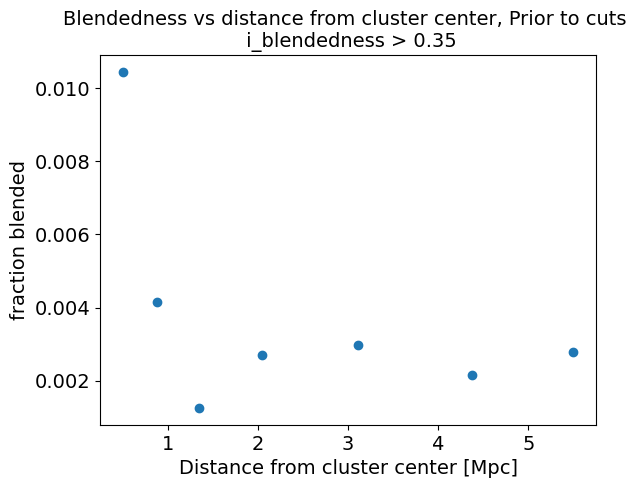

In [97]:
plot_blendedness(shear_table, bins, blended_cut, pz_tree, "Prior to cuts")

# Looking at shear outputs

## Determining tangential & cross shear

In [118]:
shear_diff = 0.02

# bins_mpc = clmm.make_bins(0.5,6,nbins=6, method='evenlog10width')
bins_mpc = clmm.make_bins((0.5/h), (3.2/(h*(1+0.22))), nbins=5, method='evenlog10width')

# bins_mpc = np.array([0.3, 0.7       , 1.06495522, 1.62018517, 2.46489237, 3.75    , 5, 6 ])
# bins_mpc = np.array([0.7       , 1.06495522, 1.62018517, 2.46489237, 3.75    , 5, 6 ])

### Global R with Beta's from Photo-z's

The $\langle\beta_s\rangle$ and $\langle\beta_s^2\rangle$ values here are calculated from the matched photo-z sample from the section above. This is to produce a slightly more informed theoretical shear profile, though in practice has little effect. 

In [119]:
p1_mean = shear_table_wl_1p[f'{meas_type}_g_1'].mean()
m1_mean = shear_table_wl_1m[f'{meas_type}_g_1'].mean()
p2_mean = shear_table_wl_2p[f'{meas_type}_g_2'].mean()
m2_mean = shear_table_wl_2m[f'{meas_type}_g_2'].mean()

r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff

r_matrix_inv = inv(r_matrix)

# calculate R error
p1_err = np.std(shear_table_wl_1p[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1p[f'{meas_type}_g_1']))
m1_err = np.std(shear_table_wl_1m[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1m[f'{meas_type}_g_1']))
p2_err = np.std(shear_table_wl_2p[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2p[f'{meas_type}_g_2']))
m2_err = np.std(shear_table_wl_2m[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2m[f'{meas_type}_g_2']))

r11_err = np.sqrt(p1_err**2 + m1_err**2)
r22_err = np.sqrt(p2_err**2 + m2_err**2)

print("R11, R22: ", r_matrix[0][0], r_matrix[1][1])
print("R11_err, R22_err: ", r11_err, r22_err)
print("Difference of R11 and R22: ", np.abs(r_matrix[0][0]-r_matrix[1][1]))

# apply R to each g1/g2 pair
g1_cal, g2_cal = r_matrix_inv.dot([shear_table_wl_ns[f'{meas_type}_g_1'], shear_table_wl_ns[f'{meas_type}_g_2']])
g_cal = np.sqrt(g1_cal*g1_cal + g2_cal*g2_cal)

# get shape uncertainties from covariance matrix
g1_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g1_cal_err, g2_cal_err = r_matrix_inv.dot([g1_err, g2_err])
g_err = (1/g_cal)*np.sqrt(g1_cal**2 * g1_err**2 + g2_cal**2 * g2_err**2)

R11, R22:  0.6785389 0.67367613
R11_err, R22_err:  0.003299928070458575 0.003328336666573783
Difference of R11 and R22:  0.0048627853


#### GC Object

In [120]:
coord = 'celestial'

galcat = GCData(meta={"coordinate_system": coord})
galcat['ra'] = shear_table_wl_ns['ra']
galcat['dec'] = shear_table_wl_ns['dec']
galcat['e1'] = g1_cal
galcat['e2'] = -g2_cal
galcat['e_err'] = g_err
galcat['id'] = np.arange(len(shear_table_wl_ns))
galcat['z'] = np.zeros(len(shear_table_wl_ns))
    
cluster_id = "Abell 360"
gc_object_beta = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat)

gc_object_beta.compute_tangential_and_cross_components(add=True)

# gc_object_beta.galcat['w_ls'] = gc_object_beta.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=True,
#         shape_component1_err="e_err",
#         shape_component2_err="e_err",
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     )

gc_object_beta.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False)

gc_object_beta.save(f'./profile_metadetect_{meas_type}_beta')

In [121]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(6.e14)

z_cl = gc_object_beta.z
z_inf = 1000

pz_estimate = shear_pz_catalogs[0][f'{pz_alg[0]}_{point_est}'][shear_pz_catalogs[0][f'{pz_alg[0]}_{point_est}']>0.37]

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_s_mean = clmm.utils.compute_beta_s_mean_from_weights(
    pz_estimate,
    z_cl,
    z_inf,
    cosmo,
    shape_weights=None,
    # shape_weights = galcat['w_ls'],
)

beta_s_square_mean = clmm.utils.compute_beta_s_square_mean_from_weights(
    pz_estimate,
    z_cl,
    z_inf,
    cosmo,
    shape_weights=None,
    # shape_weights = galcat['w_ls'],
)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

betas = np.array([beta_s_mean, beta_s_square_mean])
np.save(f'./profile_metadetect_{meas_type}_beta_betas', betas)

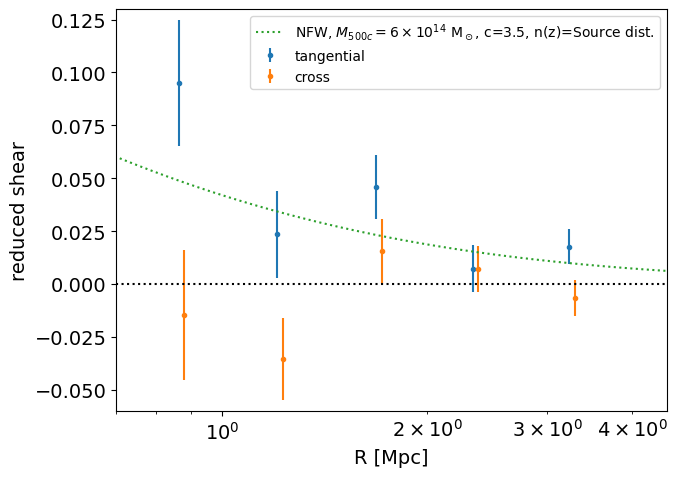

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object_beta.profile['radius'], gc_object_beta.profile['gt'], gc_object_beta.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object_beta.profile['radius']*1.02, gc_object_beta.profile['gx'], gc_object_beta.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=6 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=Source dist.', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.06,0.13])
ax.set_xlim([0.7,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=10)
fig.tight_layout()
fig.savefig(f'image_outputs_{meas_type}/shear_profile_beta.png')

In [123]:
detect_sig(gc_object_beta)

Tangential signal
Chi-squared statistic: 25.546
Degrees of freedom: 5
p-value: 1.0927e-04
Detection significance: 3.70 sigma

Cross signal
Chi-squared statistic: 5.580
Degrees of freedom: 5
p-value: 3.4923e-01
Detection significance: 0.39 sigma


175
320
691
1326
2216
Total galaxy density (per sq arcmin): 6.101783003187883, error: 0.08873971404133084


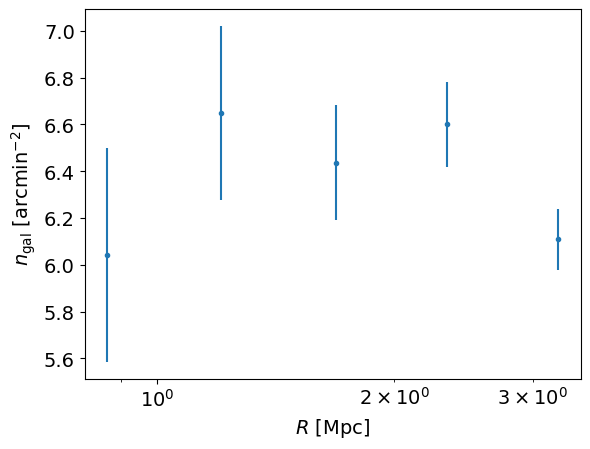

In [124]:
wl_rad, wl_den, wl_den_err = gal_den_profile(gc_object_beta, mask_hsp)

plt.errorbar(wl_rad, wl_den, wl_den_err, ls='', marker='.')
plt.xscale('log')
plt.ylabel(r'$n_{\rm gal}$ [arcmin$^{-2}$]')
plt.xlabel(r'$R$ [Mpc]')
plt.savefig(f'image_outputs_{meas_type}/gal_den_profile.png')

### Global R

In [ ]:
p1_mean = shear_table_wl_1p[f'{meas_type}_g_1'].mean()
m1_mean = shear_table_wl_1m[f'{meas_type}_g_1'].mean()
p2_mean = shear_table_wl_2p[f'{meas_type}_g_2'].mean()
m2_mean = shear_table_wl_2m[f'{meas_type}_g_2'].mean()

r_matrix = [[0, 0],[0, 0]]

r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
# r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore
# r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff
r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff

r_matrix_inv = inv(r_matrix)

# calculate R error
p1_err = np.std(shear_table_wl_1p[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1p[f'{meas_type}_g_1']))
m1_err = np.std(shear_table_wl_1m[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1m[f'{meas_type}_g_1']))
p2_err = np.std(shear_table_wl_2p[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2p[f'{meas_type}_g_2']))
m2_err = np.std(shear_table_wl_2m[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2m[f'{meas_type}_g_2']))

r11_err = np.sqrt(p1_err**2 + m1_err**2)
r22_err = np.sqrt(p2_err**2 + m2_err**2)

print("R11, R22: ", r_matrix[0][0], r_matrix[1][1])
print("R11_err, R22_err: ", r11_err, r22_err)
print("Difference of R11 and R22: ", np.abs(r_matrix[0][0]-r_matrix[1][1]))

# apply R to each g1/g2 pair
g1_cal, g2_cal = r_matrix_inv.dot([shear_table_wl_ns[f'{meas_type}_g_1'], shear_table_wl_ns[f'{meas_type}_g_2']])
g_cal = np.sqrt(g1_cal*g1_cal + g2_cal*g2_cal)

# get shape uncertainties from covariance matrix
g1_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_err = (1/g_cal)*np.sqrt(g1_cal**2 * g1_err**2 + g2_cal**2 * g2_err**2)

#### Creating a GC Object

In [ ]:
galcat = GCData()
galcat['ra'] = shear_table_wl_ns['ra']
galcat['dec'] = shear_table_wl_ns['dec']
galcat['e1'] = g1_cal
galcat['e2'] = g2_cal
# galcat['e_err'] = g_err
galcat['id'] = np.arange(len(shear_table_wl_ns))
galcat['z'] = np.zeros(len(shear_table_wl_ns))
    
cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

gc_object1.compute_tangential_and_cross_components(add=True);

# gc_object1.galcat['w_ls'] = gc_object1.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=True,
#         shape_component1_err="e_err",
#         shape_component2_err="e_err",
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     )

gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False)

# gc_object1.save(f'./profile_metadetect_{meas_type}')

In [ ]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object1.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object1.profile['radius']*1.02, gc_object1.profile['gx'], gc_object1.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
# ax.set_xlim([0.5,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
# fig.savefig(f'image_outputs_{meas_type}/shear_profile-srd.png')

In [ ]:
detect_sig(gc_object1)

In [ ]:
gal_den_profile(gc_object1, mask_hsp)

### Radial Bin R

- Calculate $R_i$ for each bin
- Calibrate individual $g_1,g_2$ for the GC object (able to customize bins later through the GC object)
    - Need to also redo calibrated errors...
- Calibrate mean $g_t/g_x$ in each bin to compare against GC object

In [ ]:
dig_mpc_bins_ns = np.digitize(shear_table_wl_ns['mpc_sep'], bins_mpc)
dig_mpc_bins_1p = np.digitize(shear_table_wl_1p['mpc_sep'], bins_mpc)
dig_mpc_bins_1m = np.digitize(shear_table_wl_1m['mpc_sep'], bins_mpc)
dig_mpc_bins_2p = np.digitize(shear_table_wl_2p['mpc_sep'], bins_mpc)
dig_mpc_bins_2m = np.digitize(shear_table_wl_2m['mpc_sep'], bins_mpc)

In [ ]:
shear_table_wl_ns = shear_table_wl_ns.copy()
shear_table_wl_ns['g1_cal'] = 0.0
shear_table_wl_ns['g2_cal'] = 0.0

for i in range(0, len(bins_mpc)-1):
    bin_filt_ns = dig_mpc_bins_ns == i+1

    # print number of galaxies in each bin
    print("Rows in bin ", i, " :", len(shear_table_wl_ns['g1_cal'][bin_filt_ns]))

    # calculate mean g1/g2 for each shear type
    bin_filt_1p = dig_mpc_bins_1p == i+1
    bin_filt_1m = dig_mpc_bins_1m == i+1
    bin_filt_2p = dig_mpc_bins_2p == i+1
    bin_filt_2m = dig_mpc_bins_2m == i+1
    
    p1_mean = shear_table_wl_1p[f'{meas_type}_g_1'][bin_filt_1p].mean()
    m1_mean = shear_table_wl_1m[f'{meas_type}_g_1'][bin_filt_1m].mean()
    p2_mean = shear_table_wl_2p[f'{meas_type}_g_2'][bin_filt_2p].mean()
    m2_mean = shear_table_wl_2m[f'{meas_type}_g_2'][bin_filt_2m].mean()

    # calculate R and relevant quantities for this bin
    r_matrix = [[0, 0],[0, 0]]

    r_matrix[0][0] = (p1_mean - m1_mean) / shear_diff
    # r_matrix[0][1] = (p2_mean - m2_mean) / shear_diff # ignore
    # r_matrix[1][0] = (p1_mean - m1_mean) / shear_diff
    r_matrix[1][1] = (p2_mean - m2_mean) / shear_diff
    
    r_matrix_inv = inv(r_matrix)
    
    # # calculate R error
    p1_err = np.std(shear_table_wl_1p[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1p[f'{meas_type}_g_1']))
    m1_err = np.std(shear_table_wl_1m[f'{meas_type}_g_1']) / np.sqrt(len(shear_table_wl_1m[f'{meas_type}_g_1']))
    p2_err = np.std(shear_table_wl_2p[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2p[f'{meas_type}_g_2']))
    m2_err = np.std(shear_table_wl_2m[f'{meas_type}_g_2']) / np.sqrt(len(shear_table_wl_2m[f'{meas_type}_g_2']))
    
    r11_err = np.sqrt(p1_err**2 + m1_err**2)
    r22_err = np.sqrt(p2_err**2 + m2_err**2)
    
    print("R11, R22: ", r_matrix[0][0], r_matrix[1][1])
    print("R11_err, R22_err: ", r11_err, r22_err)
    print("Difference of R11 and R22: ", np.abs(r_matrix[0][0]-r_matrix[1][1]))
    print()

    # apply R to each g1/g2 pair
    g1_cal, g2_cal = r_matrix_inv.dot([shear_table_wl_ns[f'{meas_type}_g_1'][bin_filt_ns], shear_table_wl_ns[f'{meas_type}_g_2'][bin_filt_ns]])

    # save calibrated shears in catalog
    shear_table_wl_ns.loc[bin_filt_ns, 'g1_cal'] = g1_cal
    shear_table_wl_ns.loc[bin_filt_ns, 'g2_cal'] = g2_cal

#### Create a GC Object

In [ ]:
# get shape uncertainties from covariance matrix
g1_err_rad = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err_rad = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_err_rad = np.mean([np.array(g1_err_rad.values), np.array(g2_err_rad.values)], axis=0) # TO-DO do proper error propagation

In [ ]:
galcat_rad = GCData(meta={"coordinate_system": coord})
galcat_rad['ra'] = shear_table_wl_ns['ra']
galcat_rad['dec'] = shear_table_wl_ns['dec']
galcat_rad['e1'] = shear_table_wl_ns['g1_cal']
galcat_rad['e2'] = -shear_table_wl_ns['g2_cal']
# galcat_rad['e_err'] = g_err_rad
# galcat_rad['hsm_weight'] = weight
galcat_rad['id'] = np.arange(len(shear_table_wl_ns))
galcat_rad['z'] = np.zeros(len(shear_table_wl_ns))
# galcat_rad['z'] = wl_table['fzb_z_median']
    
cluster_id = "Abell 360"
gc_object_rad = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat_rad)

gc_object_rad.compute_tangential_and_cross_components(add=True);

# gc_object_rad.compute_galaxy_weights(
#         shape_component1="e1",
#         shape_component2="e2",
#         use_shape_error=True,
#         shape_component1_err="e_err",
#         shape_component2_err="e_err",
#         use_shape_noise=True,
#         weight_name="w_ls",
#         cosmo=cosmo,
#         add=True,
#     ) 

gc_object_rad.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

In [ ]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object_rad.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object_rad.profile['radius'], gc_object_rad.profile['gt'], gc_object_rad.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object_rad.profile['radius']*1.02, gc_object_rad.profile['gx'], gc_object_rad.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
## fig.savefig('image_output/shear_profile-radial.png')

In [ ]:
detect_sig(gc_object_rad)

In [ ]:
gal_den_profile(gc_object_rad, mask_hsp)

# Validation

## Check g1/g2 and PSF ellipticities

Check that the PSF and object ellipticities average to ~0

In [ ]:
# print mean values
print("Mean of psfrec_g_1: ", shear_table_wl_ns['psfrec_g_1'].median())
print("Mean of psfrec_g_2: ", shear_table_wl_ns['psfrec_g_2'].median())
print("Mean of wmom_g_1: ", shear_table_wl_ns[f'{meas_type}_g_1'].median())
print("Mean of wmom_g_2: ", shear_table_wl_ns[f'{meas_type}_g_2'].median())

In [ ]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table_wl_ns['psfrec_g_1'], bins=n_bins)
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table_wl_ns['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[2].hist(shear_table_wl_ns[f'{meas_type}_g_1'], bins=n_bins)
axs[2].set_title(f'{meas_type}_g_1')
axs[3].hist(shear_table_wl_ns[f'{meas_type}_g_2'], bins=n_bins)
axs[3].set_title(f'{meas_type}_g_2')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

In [ ]:
n_bins = 50

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

axs[0].hist(shear_table_wl_ns['psfrec_g_1'], bins=n_bins)
axs[0].set_yscale('log')
axs[0].set_title('psfrec_g_1')
axs[1].hist(shear_table_wl_ns['psfrec_g_2'], bins=n_bins)
axs[1].set_title('psfrec_g_2')
axs[1].set_yscale('log')
axs[2].hist(shear_table_wl_ns[f'{meas_type}_g_1'], bins=n_bins)
axs[2].set_title(f'{meas_type}_g_1')
axs[2].set_yscale('log')
axs[3].hist(shear_table_wl_ns[f'{meas_type}_g_2'], bins=n_bins)
axs[3].set_title(f'{meas_type}_g_2')
axs[3].set_yscale('log')

fig.suptitle("Distribution of ellipticities for PSF and WMOM")

plt.show()

## Plot `T_ratio` vs S/N

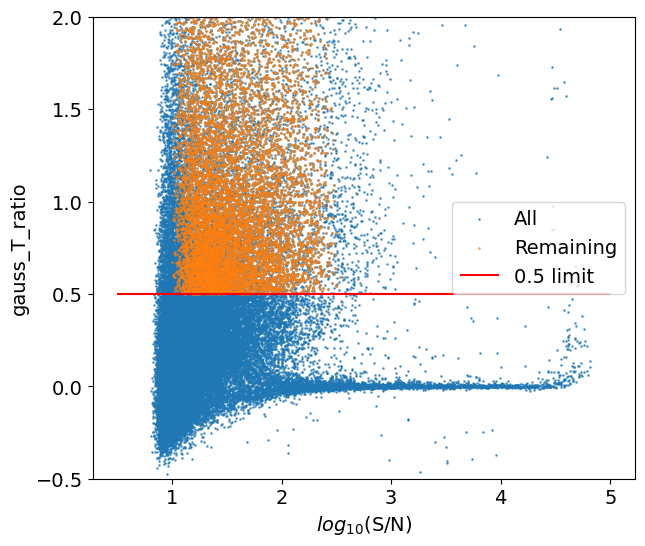

In [128]:
fig, axes = plt.subplots(1,1, figsize=(7,6))

shear_table_rs_cuts_ns = shear_table_rs_cuts[shear_table_rs_cuts['shear_type']=='ns']

axes.scatter(np.log10(shear_table_rs_cuts_ns[f'{meas_type}_s2n']), shear_table_rs_cuts_ns[f'{meas_type}_T_ratio'], 
           marker='.', s=3, alpha=point_alpha, label="All")
axes.scatter(np.log10(shear_table_wl_ns[f'{meas_type}_s2n']), shear_table_wl_ns[f'{meas_type}_T_ratio'], 
           marker='.', s=3, alpha=point_alpha, label='Remaining')
axes.set_xlabel('$log_{10}$(S/N)')
axes.set_ylabel(f'{meas_type}_T_ratio')
axes.hlines(cut_dict['t_ratio'], 0.5, 5, color='red', label=f'{cut_dict['t_ratio']} limit')

if meas_type == 'gauss':
    axes.set_ylim(-0.50, 2)

plt.legend()

plt.savefig(f'image_outputs_{meas_type}/obj_T_vs_s2n.png', bbox_inches='tight')
plt.show()

## Distribution of flux errors

Text(0.5, 0.98, 'Object Flux Errors')

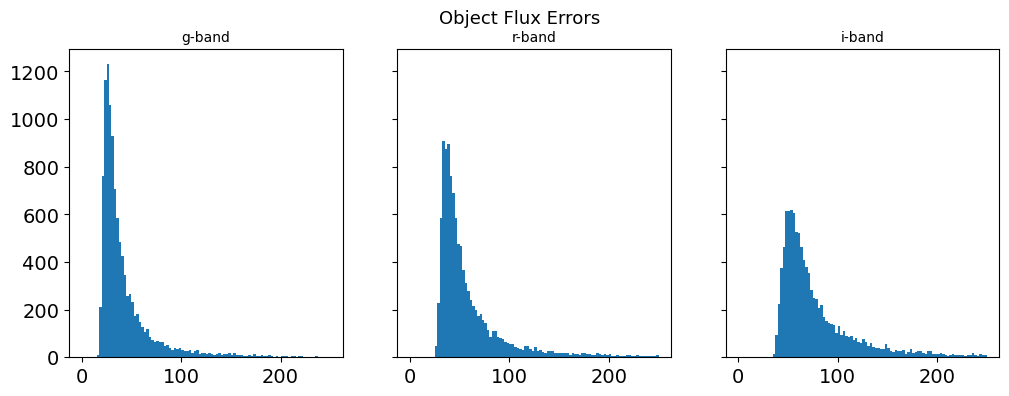

In [129]:
bin_num = 100

if meas_type=='wmom':
    hist_range = (0, 125)
    bin_num = 75
elif meas_type=='gauss':
    hist_range = (0, 250)
elif meas_type=='pgauss':
    hist_range = (0, 200)
    bin_num = 100
else:
    hist_range = None

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
ax[0].hist(shear_pz_catalogs[0][f'{meas_type}_band_flux_err_g'], range=hist_range, bins=bin_num)
ax[0].set_title("g-band", size=10)
ax[1].hist(shear_pz_catalogs[0][f'{meas_type}_band_flux_err_r'],  range=hist_range, bins=bin_num)
ax[1].set_title("r-band", size=10)
ax[2].hist(shear_pz_catalogs[0][f'{meas_type}_band_flux_err_i'],  range=hist_range, bins=bin_num)
ax[2].set_title("i-band", size=10)

plt.savefig(f'image_outputs_{meas_type}/flux-err-dist.png', bbox_inches='tight')
plt.suptitle("Object Flux Errors", size=13)

## Distribution of shape errors

Text(0.5, 0.98, 'Object Shape Errors')

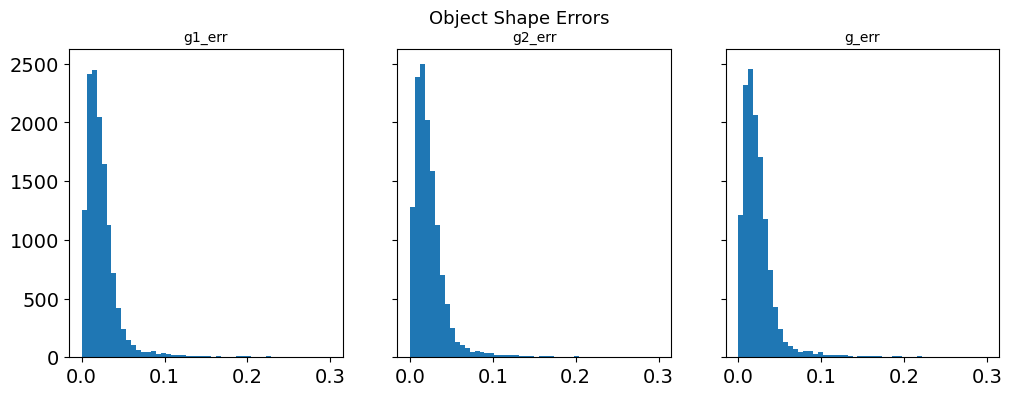

In [130]:
if meas_type=='wmom':
    bin_num=50
    hist_range=None
elif meas_type=='gauss':
    bin_num=50
    hist_range=(0,0.3)
elif meas_type=='pgauss':
    bin_num=50
    hist_range=(0,2)
else:
    print("Pick a different meas_type")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
ax[0].hist(g1_err, bins=bin_num, range=hist_range)
ax[0].set_title("g1_err", size=10)
ax[1].hist(g2_err, bins=bin_num, range=hist_range)
ax[1].set_title("g2_err", size=10)
ax[2].hist(g_err, bins=bin_num, range=hist_range)
ax[2].set_title("g_err", size=10)

plt.savefig(f'image_outputs_{meas_type}/shape-err-dist.png', bbox_inches='tight')
plt.suptitle("Object Shape Errors", size=13)

## Plot object density as a function of every cut

In [131]:
obj_density = shear_table_rs_cuts.copy()
obj_density = obj_density[obj_density['shear_type']=='ns']

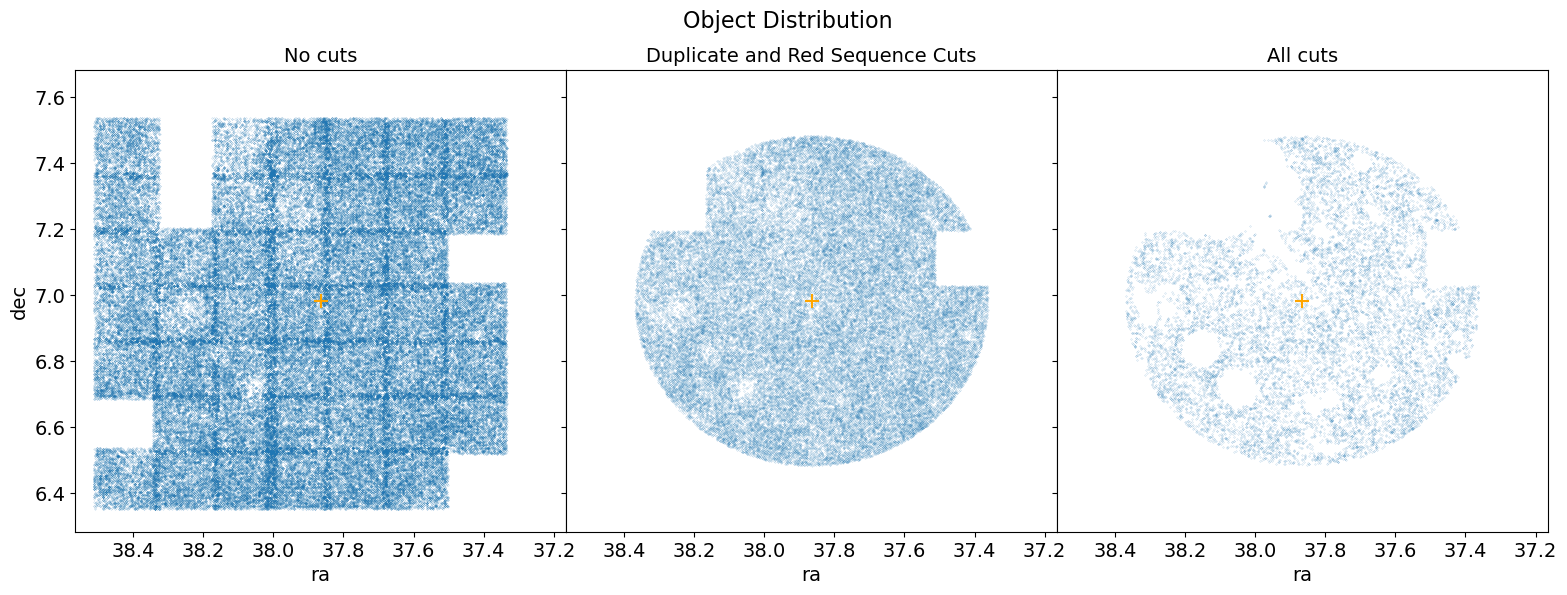

In [132]:
fig, axes = plt.subplots(1,3, figsize=(19,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

axes[0].scatter(shear_table_dup['ra'][shear_table_dup['shear_type']=='ns'], shear_table_dup['dec'][shear_table_dup['shear_type']=='ns'], marker='.', s=0.1, alpha=0.6) 
axes[0].set_title("No cuts")
axes[0].set_xlabel("ra")
axes[0].set_ylabel("dec")
axes[0].invert_xaxis()

axes[1].scatter(obj_density['ra'], obj_density['dec'], marker='.', s=0.1, alpha=0.6) 
axes[1].set_title("Duplicate and Red Sequence Cuts")
axes[1].set_xlabel("ra")
axes[1].invert_xaxis()

axes[2].scatter(shear_table_wl_ns['ra'], shear_table_wl_ns['dec'], marker='.', s=0.1, alpha=0.6) 
axes[2].set_title("All cuts")
axes[2].set_xlabel("ra")
axes[2].set_xlim(ra_bcg-0.7, ra_bcg+0.7)
axes[2].set_ylim(dec_bcg-0.7, dec_bcg+0.7)
axes[2].invert_xaxis()

for ax in axes.reshape(-1):
    ax.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')
    # ax.set_xlim(37.8, 38.0)
    # ax.set_ylim(6.9, 7.1)

plt.suptitle("Object Distribution", size=16, y=0.98)
plt.savefig(f'image_outputs_{meas_type}/object-distribution-before-after.png', bbox_inches='tight')
plt.show()

In [ ]:
obj_density_s2n = obj_density[obj_density[f'{meas_type}_s2n']>cut_dict['s2n']]
obj_density_t = obj_density[obj_density[f'{meas_type}_T']<cut_dict['T']]
obj_density_mfrac = obj_density[obj_density['mfrac']<cut_dict['mfrac']]
obj_density_gr = obj_density[(obj_density[f'{meas_type}_color_mag_g-r']).abs()<cut_dict['color']]
obj_density_ri = obj_density[(obj_density[f'{meas_type}_color_mag_r-i']).abs()<cut_dict['color']]
obj_density_gi = obj_density[(obj_density[f'{meas_type}_color_mag_g-i']).abs()<cut_dict['color']]
obj_density_bright = obj_density[obj_density[f'{meas_type}_band_mag_i']>cut_dict['bright']]
obj_density_t_ratio = obj_density[obj_density[f'{meas_type}_T_ratio']>cut_dict['t_ratio']]
obj_density_imag = obj_density[obj_density[f'{meas_type}_band_mag_i']<cut_dict['mag_i']]

# apply masks
star_mask = ~mask_hsp['bo'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True) # bright objects
dust_mask = ~mask_hsp['sfd'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True) # masks from SFD dust map
hand_mask = ~mask_hsp['hand'].get_values_pos(obj_density['ra'], obj_density['dec'], lonlat=True)  # masks done by hand, e.g. galactic cirrus
obj_mask = star_mask & dust_mask & hand_mask
obj_density_masks = obj_density[obj_mask]

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(16,13), sharex=True, sharey=True)
fig.tight_layout(h_pad=2.5, rect=[0, 0.03, 1, 0.95])

axes[0][0].scatter(obj_density['ra'], obj_density['dec'], marker='.', s=0.2) 
axes[0][0].set_title("No cuts")
axes[0][0].set_ylabel("dec")

axes[0][1].scatter(obj_density_t_ratio['ra'], obj_density_t_ratio['dec'], marker='.', s=0.2) 
axes[0][1].set_title("T_ratio")

axes[0][2].scatter(obj_density_bright['ra'], obj_density_bright['dec'], marker='.', s=0.2) 
axes[0][2].set_title("Brightness Cut")

axes[0][3].scatter(obj_density_imag['ra'], obj_density_imag['dec'], marker='.', s=0.2) 
axes[0][3].set_title("mag_i")

axes[1][0].scatter(obj_density_s2n['ra'], obj_density_s2n['dec'], marker='.', s=0.2) 
axes[1][0].set_title(f"S/N > {cut_dict['s2n']}")
axes[1][0].set_ylabel("dec")

axes[1][1].scatter(obj_density_t['ra'], obj_density_t['dec'], marker='.', s=0.2) 
axes[1][1].set_title("T")

axes[1][2].scatter(obj_density_mfrac['ra'], obj_density_mfrac['dec'], marker='.', s=0.2) 
axes[1][2].set_title("mfrac")

axes[1][3].scatter(obj_density_masks['ra'], obj_density_masks['dec'], marker='.', s=0.2) 
axes[1][3].set_title("Applied masks")

axes[2][0].scatter(obj_density_gr['ra'], obj_density_gr['dec'], marker='.', s=0.2) 
axes[2][0].set_title("g-r color cut")
axes[2][0].set_ylabel("dec")
axes[2][0].set_xlabel("ra")

axes[2][1].scatter(obj_density_ri['ra'], obj_density_ri['dec'], marker='.', s=0.2) 
axes[2][1].set_title("r-i color cut")
axes[2][1].set_xlabel("ra")

axes[2][2].scatter(obj_density_gi['ra'], obj_density_gi['dec'], marker='.', s=0.2) 
axes[2][2].set_title("g-i color cut")
axes[2][2].set_xlabel("ra")

axes[2][3].scatter(shear_table_wl_ns['ra'], shear_table_wl_ns['dec'], marker='.', s=0.2) 
axes[2][3].set_title("All cuts")
axes[2][3].set_xlabel("ra")
axes[2][3].invert_xaxis() # inverts all axes due to sharex=True

for ax in axes.reshape(-1):
    ax.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')
    # ax.invert_xaxis()

plt.suptitle("Object Distribution Per Cut", size=16, y=0.98)
plt.savefig(f'image_outputs_{meas_type}/object-distribution-cuts.png', bbox_inches='tight')
plt.show()

## Plot distribution of cell properties in A360 region

Each run of the `get_cell_inputs` function should only take 3-4 minutes. If it's longer, try again later.

In [32]:
from lsst.sphgeom import Box, HealpixPixelization
import healpy as hp
from hpgeom import hpgeom
import skyproj

# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

# define healpix parameters
nside_coverage = 2**8
nside_sparse = 2**14

pixelization = HealpixPixelization(hp.nside2order(nside_sparse))

In [33]:
# method find the pixel indices that overlap the sky projection of the cell area
def get_cell_pixels(cell, wcs):
    cell_bbox = cell.inner.bbox
    begin_coord = wcs.pixelToSky(cell_bbox.beginX, cell_bbox.beginY)
    end_coord = wcs.pixelToSky(cell_bbox.endX, cell_bbox.endY)
    
    if begin_coord.getRa() < end_coord.getRa():
        ra1 = begin_coord.getRa().asDegrees()
        ra2 = end_coord.getRa().asDegrees()
    else:
        ra1 = end_coord.getRa().asDegrees()
        ra2 = begin_coord.getRa().asDegrees()
    
    if begin_coord.getDec() < end_coord.getDec():
        dec1 = begin_coord.getDec().asDegrees()
        dec2 = end_coord.getDec().asDegrees()
    else:
        dec1 = end_coord.getDec().asDegrees()
        dec2 = begin_coord.getDec().asDegrees()

    indices = hpgeom.query_box(nside=nside_sparse, a0=ra1, a1=ra2, b0=dec1, b1=dec2)
    
    return indices

In [34]:
# return PSF e magnitude of the cell
def get_psf_e(cell, wcs):
    # get psf image of cell
    psf_im = cell.psf_image
    
    psf_kernel = afwMath.FixedKernel(psf_im)
    psf = meas.KernelPsf(psf_kernel)
    shape = psf.computeShape(psf_im.getBBox().getCenter())
    
    trace_radius = shape.getTraceRadius()
    i_xx, i_yy, i_xy = shape.getIxx(), shape.getIyy(), shape.getIxy()
    
    q = Quadrupole(i_xx, i_yy, i_xy)
    s = SeparableDistortionTraceRadius(q)
    
    e1, e2 = s.getE1(), s.getE2()
    e = np.sqrt(e1**2 + e2**2)
    
    return e

In [35]:
# returns the limiting PSF magnitude of each pixel, given the cell object and statistics settings
def get_mag_lim(cell, statsCtrl, zp=31.4, num_sigma=5):
    
    # get psf area of cell
    psf_im = cell.psf_image.array
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    psf_area = numer/denom

    # get total cell weight
    accTask = AssembleCellCoaddTask()
    mask_im = cell.inner.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/total_weight))
    
    return maglim

In [36]:
def get_cell_inputs(cell_collection, tract_patch_list, band):

    cell_df = pd.DataFrame()
    cell_ra = []
    cell_dec = []
    pixel_indices = []
    inputs_list = []
    mag_lim_list = []
    psf_e_list = []

    segs = [] # collection of lines to plot patch outlines

    for tract, patch in tract_patch_list:
    
        coadd = butler.get('deepCoaddCell', 
                         collections = cell_collection, 
                         instrument = 'LSSTComCam', 
                         skymap = 'lsst_cells_v1', 
                         tract = tract, 
                         patch = patch,
                         band = band,)
        # define a wcs from the given coadd
        wcs = coadd.wcs

        # get coadd outline
        coadd_corners = coadd.inner_bbox.getCorners()
    
        for index, corner in enumerate(coadd_corners):
            corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
            if index < 3:
                corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
            else:
                corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())
    
            start_ra = corner_coord_start[0].asDegrees()
            start_dec = corner_coord_start[1].asDegrees()
    
            end_ra = corner_coord_end[0].asDegrees()
            end_dec = corner_coord_end[1].asDegrees()
    
            segs.append(((start_ra, start_dec), (end_ra, end_dec)))
        
        cell_list = list(coadd.cells.keys()) # skips indices that are empty

        # for each cell in cell_list:
        for index, cell_index in enumerate(cell_list):
    
            cell = coadd.cells[cell_index]
    
            # get cell coordinates for removing duplicates
            cell_center = cell.inner.bbox.getCenter()
            cell_center_coord = wcs.pixelToSky(cell_center)
            cell_ra.append(cell_center_coord.getRa().asDegrees())
            cell_dec.append(cell_center_coord.getDec().asDegrees())
        
            pixel_indices.append(get_cell_pixels(cell, wcs))
    
            inputs_list.append(cell.visit_count)
            mag_lim_list.append(get_mag_lim(cell, statsCtrl))
            psf_e_list.append(get_psf_e(cell, wcs))
    
        del coadd
        gc.collect()

    cell_df["ra"] = cell_ra
    cell_df["dec"] = cell_dec
    cell_df["pixels"] = pixel_indices
    cell_df["inputs"] = inputs_list
    cell_df["mag_lim"] = mag_lim_list
    cell_df["psf_e"] = psf_e_list

    return cell_df, segs

#### g-band

In [40]:
cell_df_g, segs_g = get_cell_inputs(cell_collection, tract_patch_list, 'g')

In [41]:
# remove duplicate cells from overlapping patches
cell_df_g = cell_df_g.drop_duplicates(subset=['ra', 'dec'])

In [42]:
pixel_df_g = cell_df_g.explode('pixels').reset_index(drop=True)
pixel_df_g = pixel_df_g.drop_duplicates(subset=["pixels"]) 
pixel_df_g = pixel_df_g.dropna(subset=['pixels'])

pixels_g = pixel_df_g["pixels"].to_numpy()
pixel_input_g = pixel_df_g["inputs"].to_numpy()
pixel_mag_lim_g = pixel_df_g["mag_lim"].to_numpy()
pixel_psf_e_g = pixel_df_g["psf_e"].to_numpy()

In [43]:
hsp_map_input_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_input_g))

hsp_map_mag_lim_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_mag_lim_g))

hsp_map_psf_e_g = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_g.update_values_pix(np.array(pixels_g, dtype=np.int64), np.array(pixel_psf_e_g))

#### r-band

In [44]:
cell_df_r, segs_r = get_cell_inputs(cell_collection, tract_patch_list, 'r')

In [45]:
# remove duplicate cells from overlapping patches
cell_df_r = cell_df_r.drop_duplicates(subset=['ra', 'dec'])

In [46]:
pixel_df_r = cell_df_r.explode('pixels').reset_index(drop=True)
pixel_df_r = pixel_df_r.drop_duplicates(subset=["pixels"]) 
pixel_df_r = pixel_df_r.dropna(subset=['pixels'])

pixels_r = pixel_df_r["pixels"].to_numpy()
pixel_input_r = pixel_df_r["inputs"].to_numpy()
pixel_mag_lim_r = pixel_df_r["mag_lim"].to_numpy()
pixel_psf_e_r = pixel_df_r["psf_e"].to_numpy()

In [47]:
hsp_map_input_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_input_r))

hsp_map_mag_lim_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_mag_lim_r))

hsp_map_psf_e_r = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_r.update_values_pix(np.array(pixels_r, dtype=np.int64), np.array(pixel_psf_e_r))

#### i-band

In [48]:
cell_df_i, segs_i = get_cell_inputs(cell_collection, tract_patch_list, 'i')

In [49]:
# remove duplicate cells from overlapping patches
cell_df_i = cell_df_i.drop_duplicates(subset=['ra', 'dec'])

In [50]:
pixel_df_i = cell_df_i.explode('pixels').reset_index(drop=True)
pixel_df_i = pixel_df_i.drop_duplicates(subset=["pixels"]) 
pixel_df_i = pixel_df_i.dropna(subset=['pixels'])

pixels_i = pixel_df_i["pixels"].to_numpy()
pixel_input_i = pixel_df_i["inputs"].to_numpy()
pixel_mag_lim_i = pixel_df_i["mag_lim"].to_numpy()
pixel_psf_e_i = pixel_df_i["psf_e"].to_numpy()

In [51]:
hsp_map_input_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map_input_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_input_i))

hsp_map_mag_lim_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mag_lim_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_mag_lim_i))

hsp_map_psf_e_i = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_psf_e_i.update_values_pix(np.array(pixels_i, dtype=np.int64), np.array(pixel_psf_e_i))

#### Input Distribution Plot

The three missing patches were due to pipeline failures, though are not included within the 0.5 degree radius of the BCG

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5.3))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_input_g, vmin=1, vmax=pixel_input_i.max())
sp_g.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_g.ax.circle(ra_bcg, dec_bcg, 0.3, color='darkorange')
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_input_r, vmin=1, vmax=pixel_input_i.max())
sp_r.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_r.ax.circle(ra_bcg, dec_bcg, 0.3, color='darkorange')
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_input_i, vmin=1, vmax=pixel_input_i.max())
sp_i.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_i.ax.circle(ra_bcg, dec_bcg, 0.3, color='darkorange')
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.8, label='Number of input warps per cell')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("Input Image Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_image_distribution.png', bbox_inches='tight')
plt.show()

#### Limiting Magnitude Distribution Plot

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5.5))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_mag_lim_g)
sp_g.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_mag_lim_r)
sp_r.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_mag_lim_i)
sp_i.ax.circle(ra_bcg, dec_bcg, 0.5, color='cyan')
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.9, label='5-sigma Limiting Magnitude')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("5-sigma Limiting Magnitude Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_mag_lim_distribution.png', bbox_inches='tight')
plt.show()

These plots should be taken with a grain of salt.

#### PSF Ellipticity Distribution Plot

In [52]:
# mean PSF ellipticies for each band
print("Mean PSF ellipticity in g-band: ", pixel_psf_e_g.mean())
print("Mean PSF ellipticity in r-band: ", pixel_psf_e_r.mean())
print("Mean PSF ellipticity in i-band: ", pixel_psf_e_i.mean())
print()
# median PSF ellipticies for each band
print("Median PSF ellipticity in g-band: ", np.median(pixel_psf_e_g))
print("Median PSF ellipticity in r-band: ", np.median(pixel_psf_e_r))
print("Median PSF ellipticity in i-band: ", np.median(pixel_psf_e_i))

Mean PSF ellipticity in g-band:  0.05577143271245671
Mean PSF ellipticity in r-band:  0.06897302923912846
Mean PSF ellipticity in i-band:  0.097983572043881

Median PSF ellipticity in g-band:  0.05566510860061409
Median PSF ellipticity in r-band:  0.06720691751142543
Median PSF ellipticity in i-band:  0.09544568695565465


In [53]:
# get minimum / maximum PSF ellipticities for a consistent colorbar
print(pixel_psf_e_g.min())
print(pixel_psf_e_r.min())
print(pixel_psf_e_i.min())

print(pixel_psf_e_g.max())
print(pixel_psf_e_r.max())
print(pixel_psf_e_i.max())

0.0007714847384634084
0.002958785293608446
0.0025525399587746733
0.20220208602939163
0.19353375111919743
0.254968222542525


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(19.5, 5.5))
sp_g = skyproj.GnomonicSkyproj(ax=ax[0], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_g.draw_hspmap(hsp_map_psf_e_g, vmin=0, vmax=pixel_psf_e_i.max())
sp_g.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_g.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_g.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_g.ax.set_title("g-band", pad=25)
for seg in segs_g:
    sp_g.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

sp_r = skyproj.GnomonicSkyproj(ax=ax[1], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_r.draw_hspmap(hsp_map_psf_e_r, vmin=0, vmax=pixel_psf_e_i.max())
sp_r.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_r.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_r.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_r.ax.set_title("r-band", pad=25)
for seg in segs_r:
    sp_r.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
    
sp_i = skyproj.GnomonicSkyproj(ax=ax[2], lon_0=37.862, lat_0=6.98, min_lon_ticklabel_delta=0.2)
sp_i.draw_hspmap(hsp_map_psf_e_i, vmin=0, vmax=pixel_psf_e_i.max())
sp_i.ax.set_xlabel("RA (deg)", fontsize=10,)
sp_i.ax.set_ylabel("DEC (deg)", fontsize=10,)
sp_i.draw_colorbar(shrink=0.9, label='PSF Ellipticity Modulus')
sp_i.ax.set_title("i-band", pad=25)
for seg in segs_i:
    sp_i.ax.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)

plt.suptitle("PSF Ellipticity Distribution of the A360 Region", size=15)

plt.savefig(f'image_outputs_{meas_type}/3_band_psf_e_distribution.png', bbox_inches='tight')
plt.show()

## Investigate Patch Failures

In [ ]:
# check if any of the patches from running cell-based coadds failed
for ref in butler.registry.queryDatasets('assembleCellCoadd_log', collections=cell_collection):
    
    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue

    patch_log = butler.get('assembleCellCoadd_log', 
                     collections = cell_collection, 
                     instrument = 'LSSTComCam', 
                     skymap = 'lsst_cells_v1', 
                     tract = ref.dataId['tract'], 
                     patch = ref.dataId['patch'],
                     band = 'i')
    
    patch_error = [log['message'] for log in patch_log.model_dump() if log['levelname'] == 'ERROR']
    if len(patch_error) > 0:
        print(patch_error)

In [ ]:
# check if any patches running Metadetection have failed and why
for ref in butler.registry.queryDatasets('metadetectionShear_log', collections=collection):
    
    # the only parts of these tracts within 0.5 radius overlap with already included patches
    if ref.dataId['tract'] == 10704 or ref.dataId['tract'] == 10705:
        continue

    # these column of patches overlap with patches already in tract 10464
    if ref.dataId['tract'] == 10463 and ref.dataId['patch'] in overlap_patches_10463:
        continue
        
    patch_log = butler.get('metadetectionShear_log', 
                     collections = collection, 
                     instrument = 'LSSTComCam', 
                     skymap = 'lsst_cells_v1', 
                     tract = ref.dataId['tract'], 
                     patch = ref.dataId['patch'],
                     band = 'i')
    
    patch_error = [log['message'] for log in patch_log.model_dump() if log['levelname'] == 'ERROR']
    if len(patch_error) > 0:
        print(patch_error)

## Look at shear profile with no calibration

In [ ]:
# get shape uncertainties from covariance matrix
g1_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_11'])
g2_err = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_cov_22'])
g_no_cal = np.sqrt(shear_table_wl_ns[f'{meas_type}_g_1']**2 + shear_table_wl_ns[f'{meas_type}_g_2']**2)
g_err = (1/g_no_cal)*np.sqrt(shear_table_wl_ns[f'{meas_type}_g_1']**2 * g1_err**2 + shear_table_wl_ns[f'{meas_type}_g_2']**2 * g2_err**2)

In [ ]:
galcat_no_cal = GCData()
galcat_no_cal['ra'] = shear_table_wl_ns['ra']
galcat_no_cal['dec'] = shear_table_wl_ns['dec']
galcat_no_cal['e1'] = shear_table_wl_ns[f'{meas_type}_g_1']
galcat_no_cal['e2'] = shear_table_wl_ns[f'{meas_type}_g_2']
galcat_no_cal['e_err'] = g_err
galcat_no_cal['id'] = np.arange(len(shear_table_wl_ns))
galcat_no_cal['z'] = np.zeros(len(shear_table_wl_ns))
    
cluster_id = "Abell 360"
gc_object_no_cal = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat_no_cal, coordinate_system='euclidean')

gc_object_no_cal.compute_tangential_and_cross_components(add=True);

gc_object_no_cal.galcat['w_ls'] = gc_object_no_cal.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    )

gc_object_no_cal.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=True, gal_ids_in_bins=False);

gc_object_no_cal.save(f'./profile_metadetect_{meas_type}_no_cal')

In [ ]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(3.5)
moo.set_mass(4.e14)

z_cl = gc_object_no_cal.z

# source properties
# Wrongly assume sources redshift following a the DESC SRD distribution (pre-coded in CLMM). 
# Just to get something in the ballpark of what to expect

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

rproj = np.logspace(np.log10(0.1),np.log10(7.), 100)

gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

mpl.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

ax.errorbar(gc_object_no_cal.profile['radius'], gc_object_no_cal.profile['gt'], gc_object_no_cal.profile['gt_err'], 
             ls='', marker='.', label='tangential')
ax.errorbar(gc_object_no_cal.profile['radius']*1.02, gc_object_no_cal.profile['gx'], gc_object_no_cal.profile['gx_err'], 
             ls='', marker='.', label='cross')
ax.plot(rproj, gt_z, label=r'NFW, $M_{500c}=4 \times 10^{14}$ M$_\odot$, c=3.5, n(z)=SRD', ls=':')

ax.set_xscale('log')
ax.axhline(0.0, color='k', ls=':')
ax.set_ylim([-0.04,0.1])
ax.set_xlim([0.7,4.5])
# ax.set_xlim([0.5,4.5])
ax.set_xlabel('R [Mpc]')
ax.set_ylabel('reduced shear')
ax.legend(loc=1, fontsize=12)
fig.tight_layout()
fig.savefig(f'image_outputs_{meas_type}/shear_profile_no_cal.png')

In [ ]:
detect_sig(gc_object_no_cal)

In [ ]:
gal_den_profile(gc_object_no_cal, mask_hsp)